# Setup

This notebook will explore application of time series modeling with neural networks and TensorFlow to forecast ridership numbers for Capital Bikeshare.

Much of the methodology shared here has been drawn from and inspired by this [tutorial on time series with TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series).

The dataset we will explore here consists of [ridership counts](https://www.capitalbikeshare.com/system-data) from Washington DC's [Capital Bikeshare](https://capitalbikeshare.com/), plus weather measurements obtained from [Visual Crossing's API](https://www.visualcrossing.com/weather-api). A raw data collection pipeline is implemented in [this script](https://github.com/orthonormalize/cabi-predict/blob/master/notebooks/cabi_update_raw_data.py). The raw data also required [substantial reformatting and cleaning](https://github.com/orthonormalize/cabi-predict/blob/master/notebooks/01_data-preparation-and-EDA.ipynb), along with some corresponding exploratory analysis.

Previous jupyter notebooks:

https://github.com/orthonormalize/cabi-predict/blob/master/notebooks/00_data-acquisition.ipynb <br> https://github.com/orthonormalize/cabi-predict/blob/master/notebooks/01_data-preparation-and-EDA.ipynb

In [1]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import requests

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import time
import sqlite3

In [4]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

# GPU MEMORY GROWTH
tf.config.experimental.set_memory_growth(gpus[0], True)

# tf.debugging.set_log_device_placement(True)

2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
pd.options.display.max_rows=200
pd.options.display.max_columns=50

## Basic TF MatMul Example

In [6]:
# Create some tensors
print('a')
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print('b')
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

# This cell is weird. Sometimes it works. Sometimes it doesn't.
# Communication w GPU is inconsistent ???

# Example When it fails, the ipython log in console shows:
# 2021-04-05 10:09:27.186730: F tensorflow/stream_executor/lib/statusor.cc:34] 
# Attempting to fetch value instead of handling error Internal: 
# failed to get device attribute 13 for device 0: CUDA_ERROR_UNKNOWN: unknown error

a
b
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [7]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [20]:
# set_memory_growth solves the problem... sometimes ...
    # other times, we see this error:
    
# 2021-03-25 08:48:42.045665: F tensorflow/stream_executor/lib/statusor.cc:34] 
# Attempting to fetch value instead of handling error Internal: 
# failed to get device attribute 13 for device 0: CUDA_ERROR_UNKNOWN: unknown error
# [I 08:48:50.877 NotebookApp] KernelRestarter: restarting kernel (1/5), keep random ports
# WARNING:root:kernel 0941fbfd-c304-4326-be95-ac5b84e02ec2 restarted

# Read Data

In [21]:
def get_tables(db):
    table_names=[]
    conn = sqlite3.connect(db)
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        table_names = [ttt[0] for ttt in tables]
        conn.close()
    except:
        conn.close()
    return(table_names)

## Ridership & Weather

In [22]:
# Read {bike, dock, weather} data (1 minute)

tic=time.time()
data={}
db='cabi_data_for_TF.db'
table_names = ['bike','dock','weather']
conn=sqlite3.connect(db)
for table_name in table_names:
    query = 'select * from '+table_name                  
                # +' LIMIT 1000' # to sacrifice completeness for speed
    data[table_name]=pd.read_sql_query(query,conn)
conn.close()
print(time.time()-tic)

64.46676826477051


In [23]:
print(data['bike'].shape)
print(data['dock'].shape)
print(data['weather'].shape)

(90133, 619)
(90133, 619)
(90133, 7)


In [24]:
dt0 = pd.to_datetime(data['weather'].datetime,format='%Y-%m-%d %H:%M:%S')
dt1 = pd.to_datetime(data['bike'].datetime,format='%Y-%m-%d %H:%M:%S')
dt2 = pd.to_datetime(data['dock'].datetime,format='%Y-%m-%d %H:%M:%S')
assert all(dt0==dt1)
assert all(dt0==dt2)

In [25]:
bike=data['bike'].drop(columns='datetime')
dock=data['dock'].drop(columns='datetime')
weather=data['weather'].drop(columns='datetime')

## Stations

In [26]:
# First read station info GBFS:

url_station_info = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
sta_info = pd.DataFrame(json.loads(requests.get(url_station_info).content)['data']['stations'])
sta_info.head()

,lon,eightd_has_key_dispenser,rental_uris,region_id,eightd_station_services,name,has_kiosk,external_id,rental_methods,lat,capacity,legacy_id,station_id,electric_bike_surcharge_waiver,station_type,short_name
0,-77.053230,False,{'android': 'https://dc.lft.to/lastmile_qr_sca...,41,[],Eads St & 15th St S,True,082469cc-1f3f-11e7-bf6b-3863bb334450,"[KEY, CREDITCARD]",38.858971,15,1,1,False,classic,31000
1,-77.053320,False,{'android': 'https://dc.lft.to/lastmile_qr_sca...,41,[],18th St & S Eads St,True,08246b69-1f3f-11e7-bf6b-3863bb334450,"[KEY, CREDITCARD]",38.857250,11,2,2,False,classic,31001
2,-77.049232,False,{'android': 'https://dc.lft.to/lastmile_qr_sca...,41,[],Crystal Dr & 20th St S,True,08246c35-1f3f-11e7-bf6b-3863bb334450,"[KEY, CREDITCARD]",38.856425,17,3,3,False,classic,31002
3,-77.049417,False,{'android': 'https://dc.lft.to/lastmile_qr_sca...,41,[],Crystal Dr & 15th St S,True,08246cd5-1f3f-11e7-bf6b-3863bb334450,"[KEY, CREDITCARD]",38.861056,16,4,4,False,classic,31003
4,-77.059490,False,{'android': 'https://dc.lft.to/lastmile_qr_sca...,41,[],Aurora Hills Cmty Ctr / 18th St & S Hayes St,True,08246d68-1f3f-11e7-bf6b-3863bb334450,"[KEY, CREDITCARD]",38.857866,11,5,5,False,classic,31004


In [27]:
len(sta_info)

627

# PreProcessing & Feature Engineering

## Weather

In [30]:
weather.head()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
0,71.7,42.9,-6.156002,6.836932,0.0,0.0
1,73.6,42.5,-5.466403,7.523858,0.0,0.0
2,74.9,39.4,1.133385,-9.230679,0.0,0.0
3,76.0,39.0,3.868238,-9.112998,0.0,0.0
4,77.4,35.7,0.620833,-8.878320,0.0,0.0


In [31]:
weather.describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,59.291620,45.732405,1.310378,-0.060771,0.004610,0.044091
std,17.659689,19.053454,5.138549,7.082247,0.033818,0.545094
min,6.000000,-14.900000,-25.300000,-38.903275,0.000000,0.000000
25%,44.800000,30.400000,-1.693453,-5.200352,0.000000,0.000000
50%,60.100000,47.900000,0.555674,0.000000,0.000000,0.000000
75%,74.100000,62.600000,4.088480,5.168309,0.000000,0.000000
max,105.300000,80.300000,34.768627,27.556505,2.570000,18.220000


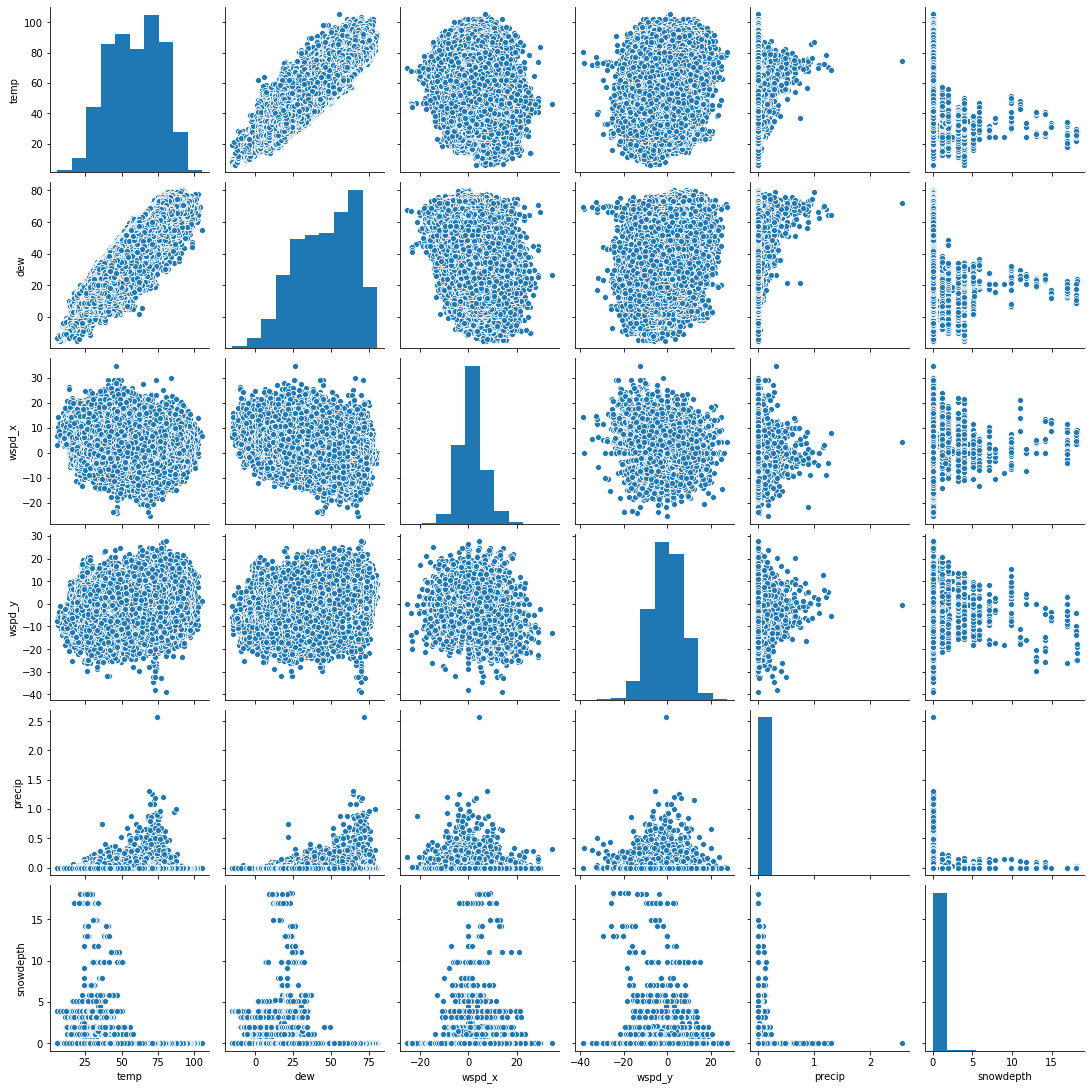

In [32]:
sns.pairplot(weather)

Four fields (temp / dew / wspd_x / wspd_y) are close to normally distributed.
The other two (precip / snowdepth) are not. These are not only positive-definite, but they are also both very right-skewed and both dominated by a large majority of zeros.

The correlated variables (e.g. temp and dew) are worth noting but won't be a problem for this task.

In [33]:
# We'll address the two strongly skewed features with the following Transformation:
# Logarithms of precip and snowdepth to make the data somewhat less right-skewed

In [34]:
weather['precip'] = np.log10(1+weather.precip)
weather['snowdepth'] = np.log10(1+weather.snowdepth)

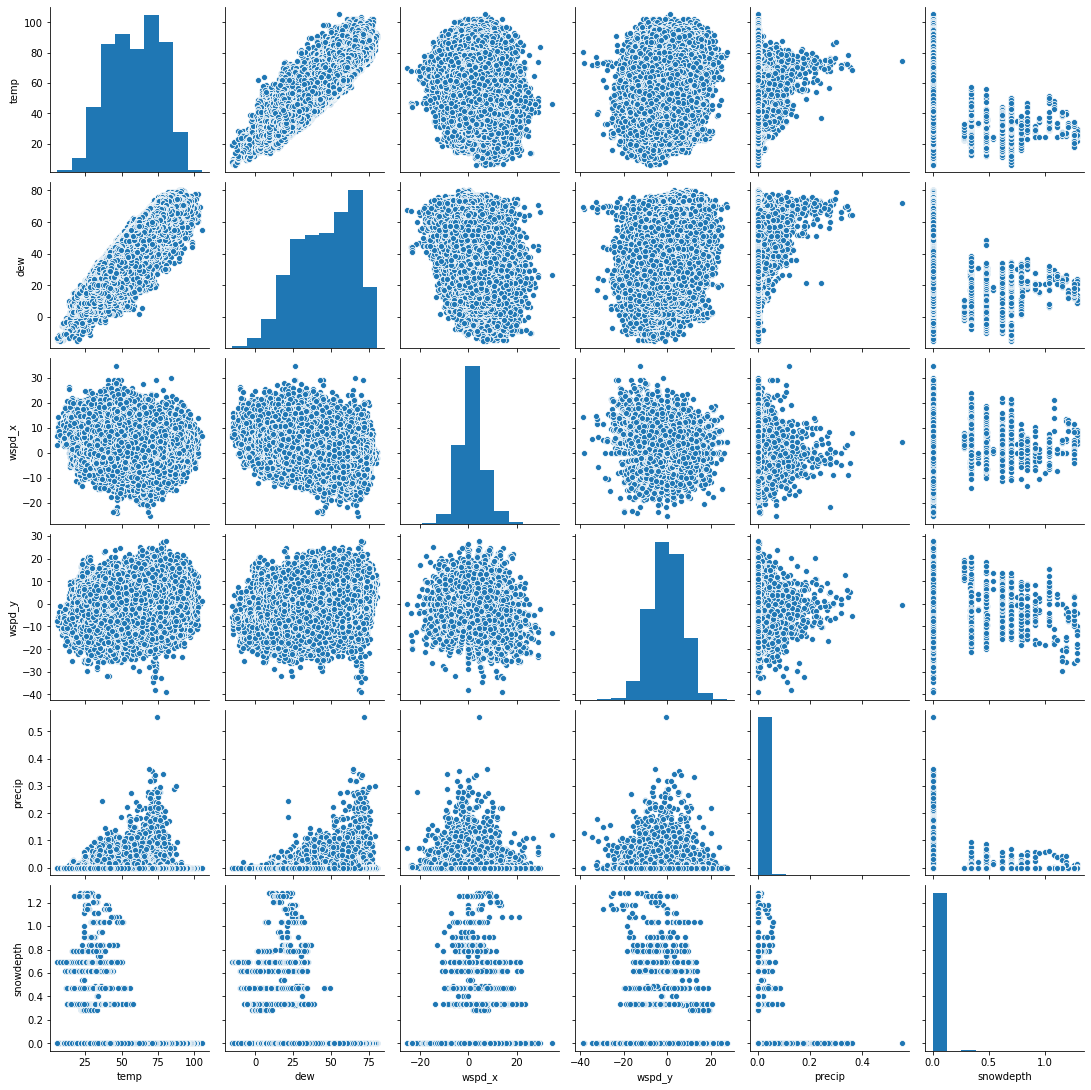

In [35]:
# Redo pairplots after transformation:
sns.pairplot(weather)

In [36]:
# The ridership data are counts, perhaps Poisson distributed.
# Consider a log transform for those as well
lbike = np.log10(1+bike)
ldock = np.log10(1+dock)

In [37]:
ldock.shape

(90133, 618)

We will also want to normalize our features as part of preprocessing. However, to avoid leakage, we'll need to define our data splitting before normalizing based on existing observations.

##  Date & Time

In [38]:
dt = pd.DataFrame(dt0,columns=['datetime'])

In [39]:
dt['hour']=dt.datetime.dt.hour
dt['doy']=dt.datetime.dt.dayofyear
dt['dow']=dt.datetime.dt.dayofweek

### Sinusoids

In [40]:
dt['day_sin']=np.sin(2*np.pi*dt.hour/24)
dt['day_cos']=np.cos(2*np.pi*dt.hour/24)
dt['week_sin']=np.sin(2*np.pi*(dt.dow+(dt.hour/24))/7)
dt['week_cos']=np.cos(2*np.pi*(dt.dow+(dt.hour/24))/7)

day = 24*60*60
year = (365.2425)*day
posix_time = dt.datetime.apply(lambda x: x.timestamp())
dt['year_sin'] = np.sin(posix_time * (2 * np.pi / year))
dt['year_cos'] = np.cos(posix_time * (2 * np.pi / year))
#dt['year_sin']=np.cos
#dt['year_cos']

In [41]:
dt

,datetime,hour,doy,dow,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
0,2010-09-20 11:00:00,11,263,0,2.588190e-01,-0.965926,0.399892,0.916562,-0.981583,-0.191034
1,2010-09-20 12:00:00,12,263,0,1.224647e-16,-1.000000,0.433884,0.900969,-0.981720,-0.190331
2,2010-09-20 13:00:00,13,263,0,-2.588190e-01,-0.965926,0.467269,0.884115,-0.981856,-0.189627
3,2010-09-20 14:00:00,14,263,0,-5.000000e-01,-0.866025,0.500000,0.866025,-0.981992,-0.188923
4,2010-09-20 15:00:00,15,263,0,-7.071068e-01,-0.707107,0.532032,0.846724,-0.982127,-0.188219
...,...,...,...,...,...,...,...,...,...,...
90128,2020-12-31 19:00:00,19,366,3,-9.659258e-01,0.258819,-0.258819,-0.965926,0.007297,0.999973
90129,2020-12-31 20:00:00,20,366,3,-8.660254e-01,0.500000,-0.294755,-0.955573,0.008014,0.999968
90130,2020-12-31 21:00:00,21,366,3,-7.071068e-01,0.707107,-0.330279,-0.943883,0.008730,0.999962
90131,2020-12-31 22:00:00,22,366,3,-5.000000e-01,0.866025,-0.365341,-0.930874,0.009447,0.999955


Text(0.5, 1.0, 'Time of day signal')

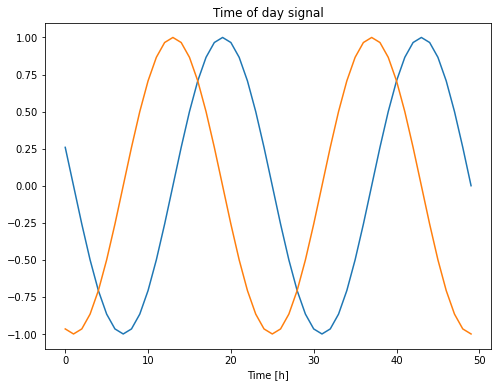

In [42]:
plt.plot(np.array(dt['day_sin'])[:50])
plt.plot(np.array(dt['day_cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

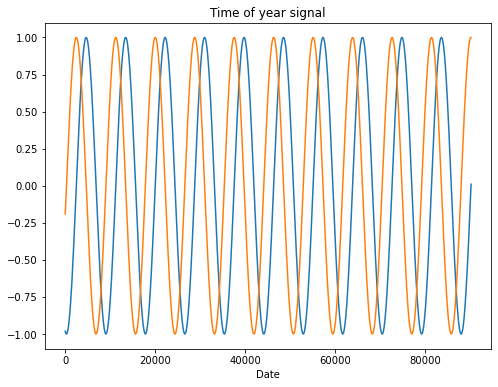

In [43]:
plt.plot(np.array(dt['year_sin']))
plt.plot(np.array(dt['year_cos']))
plt.xlabel('Date')
plt.title('Time of year signal')

Which frequencies are most prominent in the bikeshare ridership data?

Let's aggregate over all stations to investigate total system ridership

In [44]:
tic=time.time()
agg_BD = pd.concat([dt.datetime,\
                    pd.Series(bike.sum(axis=1),name='bike'),
                   pd.Series(dock.sum(axis=1),name='dock')],axis=1)
print(time.time()-tic)

0.11702108383178711


datetime
2010    AxesSubplot(0.125,0.125;0.775x0.755)
2011    AxesSubplot(0.125,0.125;0.775x0.755)
2012    AxesSubplot(0.125,0.125;0.775x0.755)
2013    AxesSubplot(0.125,0.125;0.775x0.755)
2014    AxesSubplot(0.125,0.125;0.775x0.755)
2015    AxesSubplot(0.125,0.125;0.775x0.755)
2016    AxesSubplot(0.125,0.125;0.775x0.755)
2017    AxesSubplot(0.125,0.125;0.775x0.755)
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bike, dtype: object

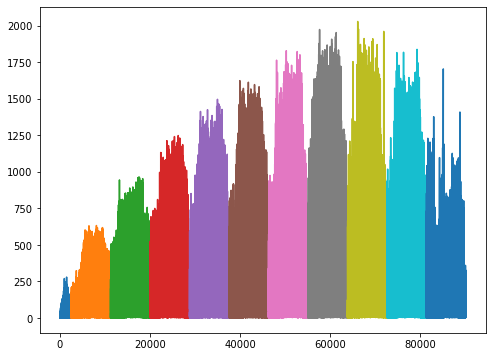

In [45]:
agg_BD.iloc[:].groupby(agg_BD.iloc[:].datetime.dt.year)['bike'].plot()

In [951]:
# Interesting figure

# Pandemic effects are visible
    # big dip spring 20
    # one high value (noise?), maybe BLM protests??
    # fall increase. what's the fall peak? more protests?
# Feb '20 relatively high compared to previous Febs?? or is that an illusion?
# Did bikeshare peak in 2018??
    # competition from scooters / Uber / etc?

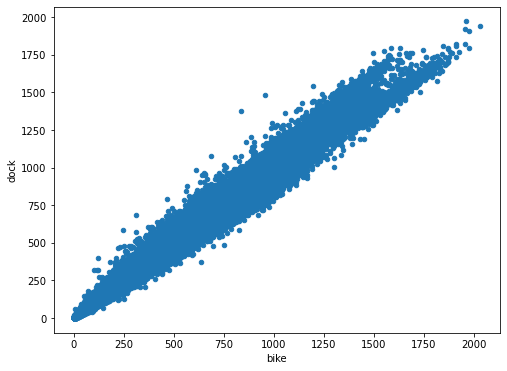

In [47]:
agg_BD.plot.scatter('bike','dock')

### FFT

In [48]:
fft = tf.signal.rfft(agg_BD.bike)

In [952]:
f_per_dataset = np.arange(0, len(fft))

In [50]:
n_samples_h = len(agg_BD.bike)
hours_per_year = 24*365.2425
years_per_dataset = n_samples_h/(hours_per_year)

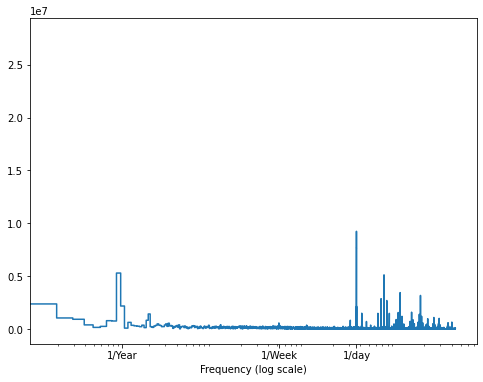

In [51]:
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2425/7, 365.2425], labels=['1/Year','1/Week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [52]:
# Yearly and Daily components are obvious
# Daily component has harmonics

# There is a very faint blip visible at weekly frequency, but not as much as I would have expected.
    # Perhaps differences in weekend ridership are 
    
    # Move this entire section back to 01 EDA ~!!!!!!!!!!!!!!!!!!11 ???
        # Then can use Member/Casual to investigate this more thoroughly


In [53]:
# Interesting, 
# Might the weekly cycle be more obvious if we downsample to a daily series from the 8am hour only?

In [54]:
agg_BD

,datetime,bike,dock
0,2010-09-20 11:00:00,2,2
1,2010-09-20 12:00:00,17,14
2,2010-09-20 13:00:00,11,13
3,2010-09-20 14:00:00,6,4
4,2010-09-20 15:00:00,12,11
...,...,...,...
90128,2020-12-31 19:00:00,95,98
90129,2020-12-31 20:00:00,83,98
90130,2020-12-31 21:00:00,49,42
90131,2020-12-31 22:00:00,42,46


In [55]:
agg_BD_h08 = agg_BD[dt.hour==8]
len(agg_BD_h08)

3755

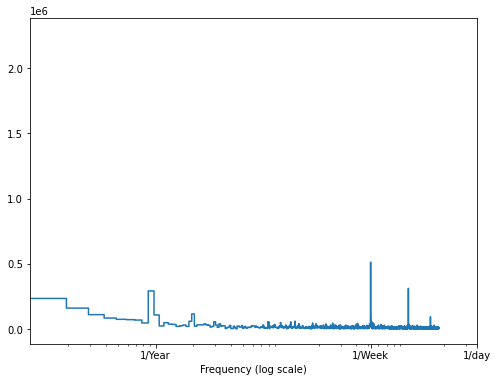

In [56]:
fft_08 = tf.signal.rfft(agg_BD_h08.bike)
f_per_dataset = np.arange(0, len(fft_08))

n_samples_days = len(agg_BD_h08.bike)
days_per_year = 365.2425
years_per_dataset = n_samples_days/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft_08))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2425/7, 365.2425], labels=['1/Year','1/Week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [57]:
# Yes! Here the weekly pattern shows the strongest signal.

# Splitting the data

## Define Splits

In [58]:
# We'll need to split data into {train, validation, test}

# Considerations:

    # 1) It's a time series, so the split must be sequential, not random
        # a) Otherwise, Leakage will help model to fit unreasonably well
        # b) Real-World Drift
    
    # 2) We expect three types of seasonality in this data:
        # a) daily
        # b) weekly
        # c) yearly
        
        # Ideally, our Train/Val/Test sub-groups should contain integer number of cycles
            # to mitigate seasonal bias
            
        # In practice, we have to choose between integer weeks vs integer years
            # choose years
            # With a full year Validation period, the weekday bias is a small fraction
    
    # 3) 2020 Pandemic: We fully expect that the coronavirus pandemic will "break" the model
        # So we'll look at results on two versions of the test set:
            # 2019
            # 2020
    
    # 4) Also we don't yet know what lag values will be most helpful for training
        # Consider two start dates for training set:
            # 2012 JAN 01
            # 2013 JAN 01
        # Why not start earlier?
            # candidate start dates allow data windows to extend back at least one full year
            # earliest data may not be super useful for prediction anyway
                # much lower volume: more noise
                # usage patterns have certainly drifted since then
    
# This leaves four combinations
    # they will be denoted by the final digit of the years defining the training set
    
    # 27: Train on 6 years (2012-2017), Val 2018, Test 2019
    # 28: Train on 7 years (2012-2018), Val 2019, Test 2020
    # 37: Train on 5 years (2013-2017), Val 2018, Test 2019
    # 38: Train on 6 years (2013-2018), Val 2019, Test 2020

In [463]:
# Boolean vectors:
splitter_masks = {}
splitter_slices = {}
for key in (27,28,37,38):
    splitter_masks[key]={}
    splitter_slices[key]={}
    first_train_year = 2010+(key//10)
    final_train_year = 2010+(key%10)
    ps_year = dt.datetime.dt.year
    for (j,key2_TVT) in enumerate(['train','val','test']):
        if (j==0):
            this_mask = ((ps_year>=first_train_year) & (ps_year<=final_train_year))
        else:
            this_mask = (ps_year==(j+final_train_year))
        included_idx = this_mask.groupby(this_mask).indices[True]
        this_slice = slice(included_idx[0],included_idx[-1]+1,1)
        splitter_masks[key][key2_TVT] = this_mask
        splitter_slices[key][key2_TVT] = this_slice

In [473]:
print(splitter_masks[27]['train'])
print()
print(sum(splitter_masks[27]['train']))

0        False
1        False
2        False
3        False
4        False
         ...  
90128    False
90129    False
90130    False
90131    False
90132    False
Name: datetime, Length: 90133, dtype: bool

52608


In [470]:
splitter_slices[27]

{'train': slice(11221, 63829, 1),
 'val': slice(63829, 72589, 1),
 'test': slice(72589, 81349, 1)}

## Scaling for weather features

In [60]:
cols_w = weather.columns

In [61]:
weather[cols_w].describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,59.291620,45.732405,1.310378,-0.060771,0.001814,0.007251
std,17.659689,19.053454,5.138549,7.082247,0.011835,0.069575
min,6.000000,-14.900000,-25.300000,-38.903275,0.000000,0.000000
25%,44.800000,30.400000,-1.693453,-5.200352,0.000000,0.000000
50%,60.100000,47.900000,0.555674,0.000000,0.000000,0.000000
75%,74.100000,62.600000,4.088480,5.168309,0.000000,0.000000
max,105.300000,80.300000,34.768627,27.556505,0.552668,1.283753


In [62]:
# Normalize wrt training set only (to avoid any leakage)

# TF notebook normalizes sinusoidal engineered datetime features along with the weather features
    # not necessary to normalize the sinusoidal features: they're already scaled well enough
(mu_w,sigma_w)=({},{})
for key in splitter_masks:
    mu_w[key]=weather.loc[splitter_masks[key]['train'],cols_w].mean().rename('mu_'+str(key))
    sigma_w[key]=weather.loc[splitter_masks[key]['train'],cols_w].std().rename('sigma_'+str(key))
pd.concat([ms[key] for key in splitter_masks for ms in (mu_w,sigma_w)],axis=1)

,mu_27,sigma_27,mu_28,sigma_28,mu_37,sigma_37,mu_38,sigma_38
temp,59.427213,17.731758,59.358951,17.815062,59.105406,17.892693,59.079351,17.961623
dew,45.461639,19.199755,45.631357,19.366675,45.296977,19.573209,45.522476,19.704407
wspd_x,1.334926,5.269942,1.271716,5.287308,1.330833,5.262557,1.257745,5.283952
wspd_y,-0.159758,7.387487,-0.180118,7.313613,-0.100299,7.371166,-0.133965,7.287628
precip,0.001615,0.010856,0.001803,0.012027,0.001657,0.011011,0.001870,0.012326
snowdepth,0.008926,0.078103,0.008003,0.073496,0.010545,0.084611,0.009198,0.078554


In [63]:
weather_stdz = {k:weather.copy() for k in splitter_masks}
for k in splitter_masks:
    weather_stdz[k][cols_w] = (weather[cols_w]-mu_w[k])/sigma_w[k]
weather_stdz[27].describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,-0.007647,0.014103,-0.004658,0.013399,0.018311,-0.021440
std,0.995936,0.992380,0.975067,0.958681,1.090185,0.890805
min,-3.013080,-3.143875,-5.054121,-5.244478,-0.148775,-0.114282
25%,-0.824916,-0.784470,-0.574651,-0.682315,-0.148775,-0.114282
50%,0.037943,0.127000,-0.147867,0.021626,-0.148775,-0.114282
75%,0.827486,0.892634,0.522502,0.721229,-0.148775,-0.114282
max,2.587041,1.814521,6.344225,3.751785,50.760196,16.322386


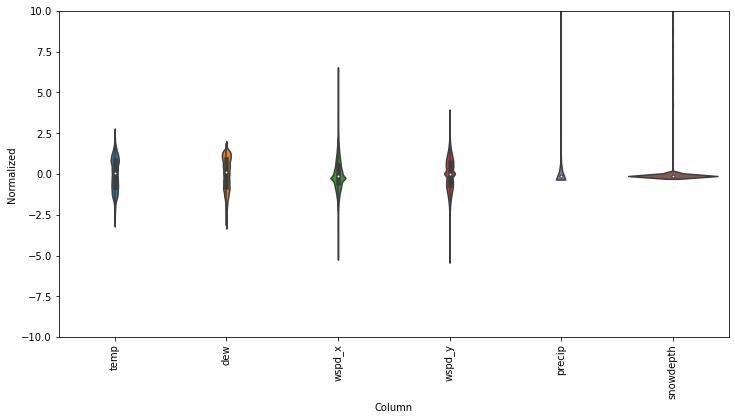

In [64]:
# Visualize violin plots for split 27:
w_melted_27 = weather_stdz[27][cols_w].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=w_melted_27)
_ = ax.set_xticklabels(cols_w, rotation=90)
_ = ax.set_ylim((-10, 10))

But the only real purpose of normalization is to scale the data to facilitate more efficient training. Doesn't need to be perfect. We can just base all of our normalization computations off of dataset 27.

## Generate full dataframe

In [65]:
u_sta = list(bike.columns[1:])
assert all(dock.columns[1:]==u_sta)
u_sta[:5] # columns of ridership data are strings of the terminal names

['31001', '31002', '31003', '31004', '31005']

In [66]:
d_colsB = {c:('B_'+str(c)) for c in bike.columns}
d_colsD = {c:('D_'+str(c)) for c in dock.columns}
df_bike = bike.rename(columns=d_colsB)
df_dock = dock.rename(columns=d_colsD)
df_bike.head()

,B_31000,B_31001,B_31002,B_31003,B_31004,B_31005,B_31006,B_31007,B_31009,B_31010,B_31011,B_31012,B_31013,B_31014,B_31015,B_31016,B_31017,B_31018,B_31019,B_31020,B_31021,B_31022,B_31023,B_31024,B_31025,...,B_32409,B_32410,B_32411,B_32412,B_32413,B_32414,B_32415,B_32416,B_32417,B_32418,B_32419,B_32420,B_32421,B_32422,B_32423,B_32600,B_32601,B_32602,B_32603,B_32604,B_32605,B_32606,B_32607,B_32608,B_32609
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
cols_dt = ['day_sin','day_cos','week_sin','week_cos','year_sin','year_cos']
cols_B = list(d_colsB.values())
cols_D = list(d_colsD.values())
cols_w = list(cols_w)

In [68]:
agg_BD

,datetime,bike,dock
0,2010-09-20 11:00:00,2,2
1,2010-09-20 12:00:00,17,14
2,2010-09-20 13:00:00,11,13
3,2010-09-20 14:00:00,6,4
4,2010-09-20 15:00:00,12,11
...,...,...,...
90128,2020-12-31 19:00:00,95,98
90129,2020-12-31 20:00:00,83,98
90130,2020-12-31 21:00:00,49,42
90131,2020-12-31 22:00:00,42,46


In [475]:
# C === Calendar/Clock sinusoids
# W === Weather
# A === Ridership counts, aggregated over all stations
# S === Ridership counts, by station

# Regardless of eventual split, we can use normalizations defined by split 27 only
tic=time.time()
k=27 # 

df_TW = pd.concat([dt[cols_dt],weather_stdz[k][cols_w]],axis=1)

rides_agg = agg_BD.drop('datetime',axis=1)
cu_renamer = lambda x: ('cu'+x)
curides_agg = rides_agg.cumsum().rename(columns=cu_renamer)
cudf_bike = df_bike.cumsum().rename(columns=cu_renamer)
cudf_dock = df_dock.cumsum().rename(columns=cu_renamer)

df_TWA = pd.concat([df_TW,rides_agg,curides_agg],axis=1)
df_TWS = pd.concat([df_TW,df_bike,df_dock,cudf_bike,cudf_dock],axis=1)

print(time.time()-tic)

2.180999279022217


In [476]:
print(df_TWA.shape)
print(df_TWS.shape)

(90133, 16)
(90133, 2484)


In [477]:
sys.getsizeof(df_TWS)
# another set of tables for DB

1791123128

In [501]:
print(df_TWA.columns)
print(df_TWS.columns[list(range(15))+list(range(-3,0,1))])

Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'bike',
       'dock', 'cubike', 'cudock'],
      dtype='object')
Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'B_31000',
       'B_31001', 'B_31002', 'cuD_32607', 'cuD_32608', 'cuD_32609'],
      dtype='object')


In [496]:
df_TWA.drop(['cubike','cudock'],axis=1)

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
0,2.588190e-01,-0.965926,0.399892,0.916562,-0.981583,-0.191034,0.692136,-0.133420,-1.421444,0.947100,-0.148775,-0.114282,2,2
1,1.224647e-16,-1.000000,0.433884,0.900969,-0.981720,-0.190331,0.799288,-0.154254,-1.290589,1.040085,-0.148775,-0.114282,17,14
2,-2.588190e-01,-0.965926,0.467269,0.884115,-0.981856,-0.189627,0.872603,-0.315714,-0.038244,-1.227876,-0.148775,-0.114282,11,13
3,-5.000000e-01,-0.866025,0.500000,0.866025,-0.981992,-0.188923,0.934639,-0.336548,0.480710,-1.211947,-0.148775,-0.114282,6,4
4,-7.071068e-01,-0.707107,0.532032,0.846724,-0.982127,-0.188219,1.013593,-0.508425,-0.135503,-1.180180,-0.148775,-0.114282,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90128,-9.659258e-01,0.258819,-0.258819,-0.965926,0.007297,0.999973,-0.909510,-0.701136,-0.777364,-0.744860,-0.148775,-0.114282,95,98
90129,-8.660254e-01,0.500000,-0.294755,-0.955573,0.008014,0.999968,-0.948987,-0.638635,-0.852229,-0.854358,-0.148775,-0.114282,83,98
90130,-7.071068e-01,0.707107,-0.330279,-0.943883,0.008730,0.999962,-0.943348,-0.763637,1.414223,0.823988,-0.148775,-0.114282,49,42
90131,-5.000000e-01,0.866025,-0.365341,-0.930874,0.009447,0.999955,-1.005383,-0.857388,0.987784,0.713334,-0.148775,-0.114282,42,46


In [497]:
df_TWAI = df_TWA.drop(['cubike','cudock'],axis=1)
df_TWAC = df_TWA.drop(['bike','dock'],axis=1)
df_TWSI = df_TWS.drop([c for c in df_TWS.columns if c.startswith('cu')],axis=1)
df_TWSC = df_TWS.drop([c for c in df_TWS.columns if (c.startswith('B_') or c.startswith('D_'))],axis=1)

In [500]:
print(df_TWAI.columns)
print(df_TWAC.columns)
print(df_TWSI.columns[list(range(15))+list(range(-3,0,1))])
print(df_TWSC.columns[list(range(15))+list(range(-3,0,1))])

Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'bike',
       'dock'],
      dtype='object')
Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'cubike',
       'cudock'],
      dtype='object')
Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'B_31000',
       'B_31001', 'B_31002', 'D_32607', 'D_32608', 'D_32609'],
      dtype='object')
Index(['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
       'temp', 'dew', 'wspd_x', 'wspd_y', 'precip', 'snowdepth', 'cuB_31000',
       'cuB_31001', 'cuB_31002', 'cuD_32607', 'cuD_32608', 'cuD_32609'],
      dtype='object')


In [72]:
df_trial = df_CWA.drop(['cubike','cudock'],axis=1)
df_trial[splitter_masks[27]['val']] # display val set df, which is just CY2018:

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
63829,0.000000,1.000000,0.000000,1.000000,0.006193,0.999981,-2.381445,-2.263656,0.471743,-1.258549,-0.148775,-0.114282,33,31
63830,0.258819,0.965926,0.037391,0.999301,0.006910,0.999976,-2.432202,-2.263656,0.559306,-0.622183,-0.148775,-0.114282,49,47
63831,0.500000,0.866025,0.074730,0.997204,0.007626,0.999971,-2.432202,-2.216780,0.737771,-0.455250,-0.148775,-0.114282,37,42
63832,0.707107,0.707107,0.111964,0.993712,0.008343,0.999965,-2.449120,-2.216780,0.958011,-0.561223,-0.148775,-0.114282,9,11
63833,0.866025,0.500000,0.149042,0.988831,0.009060,0.999959,-2.511156,-2.216780,0.879482,-0.390116,-0.148775,-0.114282,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72584,-0.965926,0.258819,0.652287,0.757972,-0.001563,0.999999,-0.712124,0.033248,-0.253310,0.021626,5.788766,-0.114282,69,78
72585,-0.866025,0.500000,0.680173,0.733052,-0.000846,1.000000,-0.700845,-0.024044,-0.253310,0.021626,-0.148775,-0.114282,54,54
72586,-0.707107,0.707107,0.707107,0.707107,-0.000129,1.000000,-0.695205,0.033248,-0.184113,0.301571,0.249288,-0.114282,62,63
72587,-0.500000,0.866025,0.733052,0.680173,0.000588,1.000000,-0.604972,0.127000,0.091279,0.504066,-0.148775,-0.114282,50,51


# Data Windowing

## TensorFlow

In [73]:
# tutorial hardcodes train_df, val_df, and test_df into WindowGenerator
    # they are all separate dfs
    
# first run: try this with the 27 splits and aggregated ridership ===> df_TWAI

# As a general rule, I dislike this workflow design
# with timeseries, one should be able to reference the same data across T/V/T
    # example: targets at time step t become predictors at time step t+k
        # where k is within your look-back window
        # e.g. to compute predictions for the first k data points in the val set,
            # one needs access to data from the end of the training set
        # The workflow shown in TF's example is discarding points near the split boundaries
            # okay if your val/test sets are each much larger than your window
            # but if you want to consider windows that look into distant past
                # this will fail
            # e.g. perhaps it's useful to look at counts from one or two years ago
                # to make current predictions
                # (c.f. long-range interactions in ATTENTION MODELS)
                # to predict ridership for New Year's Eve 2019, 
                    # maybe previous NYE events are more helpful than recent weeks
                # challenge: huge windows are cumbersome
                    # possible solution: perhaps an attention-like mechanism 
                    # or a sparse window structure
                    # (c.f. Laurence's TS wk1)
                        # he removes seasonality by feature-engineering windows around
                            # t minus exactly one year

In [504]:
k=27
train_df = df_TWAI[splitter_masks[k]['train']]
val_df = df_TWAI[splitter_masks[k]['val']]
test_df = df_TWAI[splitter_masks[k]['test']]

### WindowGenerator

In [616]:
class tf_WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                             train_df=train_df, val_df=val_df, test_df=test_df,
                             label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                                     enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

Define some windows here: 

In [617]:
w1t = tf_WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['bike'])
w1t

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['bike']

In [618]:
w2t = tf_WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['bike'])
w2t

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['bike']

In [619]:
w3t = tf_WindowGenerator(input_width=7,label_width=5,shift=17,
                       label_columns=['dock'])
w3t

Total window size: 24
Input indices: [0 1 2 3 4 5 6]
Label indices: [19 20 21 22 23]
Label column name(s): ['dock']

In [682]:
w4t = tf_WindowGenerator(input_width=10,label_width=7,shift=3,
                        label_columns=['bike','dock'])
w4t

Total window size: 13
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 6  7  8  9 10 11 12]
Label column name(s): ['bike', 'dock']

In [681]:
w5t = tf_WindowGenerator(input_width=9999,label_width=1,shift=1,
                        label_columns=['bike','dock'])
w5t

Total window size: 10000
Input indices: [   0    1    2 ... 9996 9997 9998]
Label indices: [9999]
Label column name(s): ['bike', 'dock']

In [621]:
w8t = tf_WindowGenerator(input_width=24,label_width=24,shift=1,
                       label_columns=['bike','dock'])
w8t 

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['bike', 'dock']

### split_window

In [622]:
def tf_split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

tf_WindowGenerator.split_window = tf_split_window

In [623]:
# Stack three slices, the length of the total window:
w2t_example_window = tf.stack([np.array(train_df[:w2t.total_window_size]),
                           np.array(train_df[100:100+w2t.total_window_size]),
                           np.array(train_df[200:200+w2t.total_window_size])])

w2t_example_inputs, w2t_example_labels = w2t.split_window(w2t_example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {w2t_example_window.shape}')
print(f'Inputs shape: {w2t_example_inputs.shape}')
print(f'labels shape: {w2t_example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)


In [624]:
# all about f-strings:     https://www.python.org/dev/peps/pep-0498/

In [625]:
# Two more examples:
w3t_example_window = tf.stack([np.array(train_df[:w3t.total_window_size]),
                           np.array(train_df[100:100+w3t.total_window_size]),
                           np.array(train_df[200:200+w3t.total_window_size])])

w3t_example_inputs, w3t_example_labels = w3t.split_window(w3t_example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {w3t_example_window.shape}')
print(f'Inputs shape: {w3t_example_inputs.shape}')
print(f'labels shape: {w3t_example_labels.shape}')

w8t_example_window = tf.stack([np.array(train_df[:w8t.total_window_size]),
                           np.array(train_df[100:100+w8t.total_window_size]),
                           np.array(train_df[200:200+w8t.total_window_size])])

w8t_example_inputs, w8t_example_labels = w8t.split_window(w8t_example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {w8t_example_window.shape}')
print(f'Inputs shape: {w8t_example_inputs.shape}')
print(f'labels shape: {w8t_example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 24, 14)
Inputs shape: (3, 7, 14)
labels shape: (3, 5, 1)
All shapes are: (batch, time, features)
Window shape: (3, 25, 14)
Inputs shape: (3, 24, 14)
labels shape: (3, 24, 2)


### plot

In [626]:
def tf_plot(self, model=None, plot_col='bike', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

tf_WindowGenerator.plot = tf_plot

In [627]:
w2t.example = w2t_example_inputs, w2t_example_labels
w3t.example = w3t_example_inputs, w3t_example_labels
w8t.example = w8t_example_inputs, w8t_example_labels

# manually set these object attributes for now
    # eventually they define a property '.example' within the WindowGenerator class
        # that will do this automatically
    # odd choice of name for this prop?  i suppose it is selecting 3 ts => batch

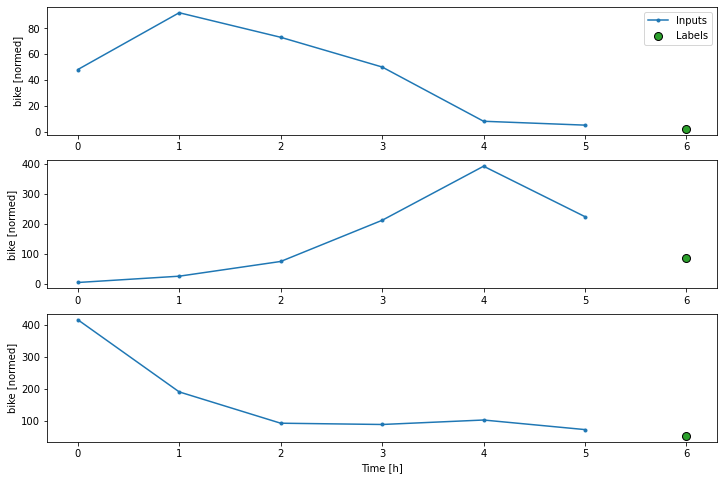

In [628]:
w2t.plot()

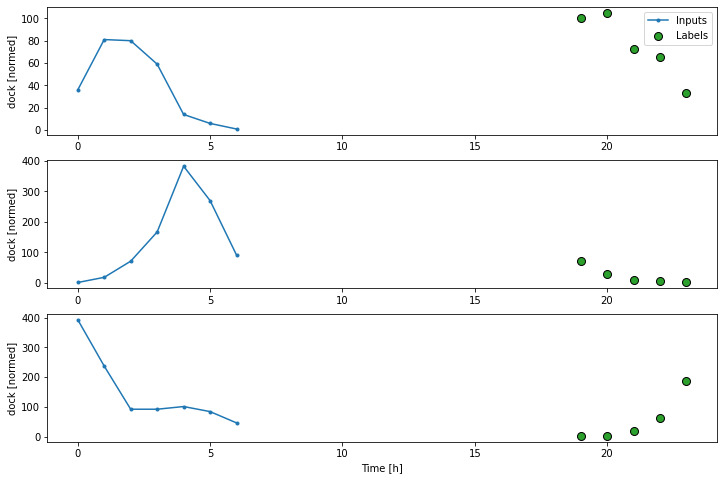

In [629]:
w3t.plot(plot_col='dock')

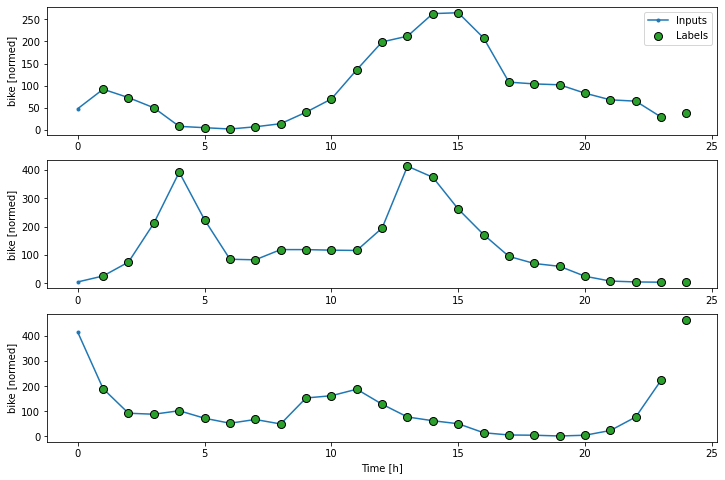

In [630]:
w8t.plot()

### timeseries_dataset_from_array

In [631]:
# Tutorial calls tf.keras.preprocessing.timeseries_dataset_from_array()
# However, this function did not exist in version 2.1 
        # (which I'm using for compatibility with my GPU)
# But we can copy the source code from GitHub and implement it directly here

In [632]:
# timeseries_dataset_from_array()
# Here's the raw version from Tensorflow, cloned from Github, 
    # unedited, except for the function name 'tf_'+

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export

def tf_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.
    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.
    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.
    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.
    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:
    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```
    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).
    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:
    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
            lambda steps, inds: array_ops.gather(steps, inds),    # pylint: disable=unnecessary-lambda
            num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

In [633]:
# example: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/preprocessing/timeseries.py#L29-L199

### make_dataset()

In [634]:
def tf_make_dataset(self, data, batch_size=32):
    data = np.array(data, dtype=np.float32)
    ds = tf_timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size,) # BatchDataset (None,None,num_features) 
                                # => (batch_size,total_window_size,num_features)

    ds = ds.map(self.split_window)

    return ds

tf_WindowGenerator.make_dataset = tf_make_dataset

In [635]:
@property
def tf_train(self):
    return self.make_dataset(self.train_df)

@property
def tf_val(self):
    return self.make_dataset(self.val_df)

@property
def tf_test(self):
    return self.make_dataset(self.test_df)

@property
def tf_example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

# These are Functions with hard returns
    # the function handle retains iterable 
tf_WindowGenerator.train = tf_train
tf_WindowGenerator.val = tf_val
tf_WindowGenerator.test = tf_test

tf_WindowGenerator.example = tf_example

In [692]:
def print_batch_structure(bds,batch_size_requested=32):
    '''
    Print the shapes of inputs and labels yielded from a BatchDataset 
    Assumes that the objects yielded are tuples of (inputs, labels)
    '''
    
    num_batches=0
    prev_batch_size=batch_size_requested
    for jjinput,jjlabel in bds:
        this_batch_size = jjinput.shape[0]
        if (this_batch_size!=prev_batch_size):
            print(f'{num_batches} batches of size {prev_batch_size}')
            print(' '*25 + f' Inputs: {tuple([prev_batch_size]+jjinput.shape[1:])},'
                          f' Labels: {tuple([prev_batch_size]+jjinput.shape[1:])}')
            num_batches=1
            prev_batch_size=this_batch_size
        else:
            num_batches+=1
    print(f'{num_batches} batches of size {prev_batch_size}')
    if num_batches:
        print(' '*25 + f' Inputs: {jjinput.shape}, Labels: {jjlabel.shape}')


In [693]:
print_batch_structure(w1t.test)

272 batches of size 32
                          Inputs: (32, 24, 14), Labels: (32, 24, 14)
1 batches of size 9
                          Inputs: (9, 24, 14), Labels: (9, 1, 1)


In [694]:
print_batch_structure(w2t.test)

273 batches of size 32
                          Inputs: (32, 6, 14), Labels: (32, 6, 14)
1 batches of size 18
                          Inputs: (18, 6, 14), Labels: (18, 1, 1)


In [695]:
print_batch_structure(w3t.test)

273 batches of size 32
                          Inputs: (32, 7, 14), Labels: (32, 7, 14)
1 batches of size 1
                          Inputs: (1, 7, 14), Labels: (1, 5, 1)


In [696]:
print_batch_structure(w5t.test)

0 batches of size 32


## My Edits

In [640]:
# Summary of Issues:

# fix edge effects at split_points
# TSDSFA bug? cutting off end
# make_dataset() and TSDSFA() working off slices
# more general window splits ????
# plotting: show time step


In [641]:
splitter_slices[27]

{'train': slice(11221, 63829, 1),
 'val': slice(63829, 72589, 1),
 'test': slice(72589, 81349, 1)}

### WindowGenerator

In [642]:
class rek_WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                             split_id=27, df=df_TWAI,
                             label_columns=None):
        # Store the raw data.
        self.df = df
        self.split_id = split_id
        self.slices_TVT = splitter_slices[split_id]
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                                     enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

In [697]:
w1r = rek_WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['bike'])
w2r = rek_WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['bike'])
w3r = rek_WindowGenerator(input_width=7,label_width=5,shift=17,
                       label_columns=['dock'])
w4r = rek_WindowGenerator(input_width=10,label_width=7,shift=3,
                        label_columns=['dock'])
w5r = rek_WindowGenerator(input_width=9999,label_width=1,shift=1,
                        label_columns=['bike','dock'])
w8r = rek_WindowGenerator(input_width=24,label_width=24,shift=1,
                       label_columns=['bike','dock'])

### split_window

In [698]:
# Modify this for more general window functions?
# First try, leave as is

def rek_split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

rek_WindowGenerator.split_window = rek_split_window

In [699]:
# Stack three slices
    # each of them is the length of the total window
    
# We're emulating a batch_size of 3 examples
# gathering relevant timeslice for each example
# and collecting the full feature vector at each point within that timeslice

my_batch=[0,10000,20000] # select time-steps to use as examples, emulating a batch
            # we'll generate len(my_batch) windows  
            # window for example b begins at timestep=my_batch[b]
    

# Try a few different timeslice windows and inspect output shapes:
w2r_example_window = tf.stack([np.array(train_df[b:(b+w2r.total_window_size)]) for b in my_batch])
        # result: a TF Tensor w/ shape=(batch, timesteps, features)
w2r_example_inputs, w2r_example_labels = w2r.split_window(w2r_example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {w2r_example_window.shape}')
print(f'Inputs shape: {w2r_example_inputs.shape}')
print(f'labels shape: {w2r_example_labels.shape}')

w3r_example_window = tf.stack([np.array(train_df[b:(b+w3r.total_window_size)]) for b in my_batch])
w3r_example_inputs, w3r_example_labels = w3r.split_window(w3r_example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {w3r_example_window.shape}')
print(f'Inputs shape: {w3r_example_inputs.shape}')
print(f'labels shape: {w3r_example_labels.shape}') # last dim is num_labels in this case

w8r_example_window = tf.stack([np.array(train_df[b:(b+w8r.total_window_size)]) for b in my_batch])
w8r_example_inputs, w8r_example_labels = w8r.split_window(w8r_example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {w8r_example_window.shape}')
print(f'Inputs shape: {w8r_example_inputs.shape}')
print(f'labels shape: {w8r_example_labels.shape}') #overlapping wide_window



All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)
All shapes are: (batch, time, features)
Window shape: (3, 24, 14)
Inputs shape: (3, 7, 14)
labels shape: (3, 5, 1)
All shapes are: (batch, time, features)
Window shape: (3, 25, 14)
Inputs shape: (3, 24, 14)
labels shape: (3, 24, 2)


### plot

In [700]:
w2r.example = my_batch, w2r_example_inputs, w2r_example_labels
w3r.example = my_batch, w3r_example_inputs, w3r_example_labels
w8r.example = my_batch, w8r_example_inputs, w8r_example_labels
# manually set these object attributes for now
    # eventually they will define a property '.example' within the WindowGenerator class
        # that will do this automatically
    # odd choice of name for this prop?  i suppose it is selecting 3 ts => batch

AttributeError: can't set attribute

In [701]:
def rek_plot(self, model=None, plot_col='bike', max_subplots=3):
    intuple = self.example
    if (len(intuple)==3):
        batch_ts, inputs, labels = self.example
    if (len(intuple)==2):
        # hack: for auto-gen examples, if shuffled, the batch_ts might not be available
        # in this case, just paste in an array of zeros here instead
        inputs, labels = self.example
        batch_ts = [0]*len(inputs) 
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        starttime = batch_ts[n]
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(starttime+self.input_indices, inputs[n, :, plot_col_index],
                         label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(starttime+self.label_indices, labels[n, :, label_col_index],
                                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(starttime+self.label_indices, predictions[n, :, label_col_index],
                                    marker='X', edgecolors='k', label='Predictions',
                                    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

rek_WindowGenerator.plot = rek_plot

### timeseries_dataset_from_array

In [702]:
def rek_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        label_width=1,
        label_mask=None,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.
    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.
    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the full output sequences (in number of timesteps).
        label_width: Length of the portion of output sequences to be used as labels
            Must be less than or equal to sequence_length.
            Assumption: the label indices are always at the high end of the sequence.
            New param: Only validated for ((sequence_stride==1) and (sampling_rate==1))
        label_mask: None (default), or slice object
            Used for sequence down-selection
            so that output labels (defined by label_width) are all inside label_mask.
            Width of slice must be greater than or equal to label_width.
            If provided, this parameter overrides start_index and end_index
            New param: Only validated for ((sequence_stride==1) and (sampling_rate==1))
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.
    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.
    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:
    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```
    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).
    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:
    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if ((label_width!=1) or (label_mask is not None)):
        if ((sequence_stride!=1) or (sampling_rate!=1)):
            raise ValueError('Bad input value(s). '
                                         'To use rek modification: sequence_stride '
                                         'and sampling_rate must both equal 1')
            
    if (label_width>sequence_length):
        raise ValueError('label_width must be less than or equal to sequence_length. Got: '
                                             'label_width=%s, sequence_length=%s.' %
                                             (label_width, sequence_length))
    if (isinstance(label_mask,slice)):
        assert ((label_mask.step is None) or (label_mask.step==1)),\
                'only validating label_mask code for unit step size'
        end_index = label_mask.stop
        start_index = max(0,label_mask.start - sequence_length + label_width)
    else:
        assert (label_mask is None), 'if provided, label_mask must be a slice object'
        
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)
    
    # Determine the lowest dtype to store start positions (to lower memory usage).
    #num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1   ######## BUG !!!!??
    num_seqs = end_index - start_index - sampling_rate*(sequence_length-1)
    # TF BUG FIXED ^
    
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset

# No changes to sequences_from_indices() :
def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
            lambda steps, inds: array_ops.gather(steps, inds),    # pylint: disable=unnecessary-lambda
            num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

### make_dataset

In [703]:
def rek_make_dataset(self, data, tvt='train', shuffle=True, batch_size=32):
    data = np.array(data, dtype=np.float32)
    ds = rek_timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            label_width=self.label_width,
            label_mask=self.slices_TVT[tvt],
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=batch_size,) # BatchDataset (None,None,num_features) 
                                # => (batch_size,total_window_size,num_features)

    ds = ds.map(self.split_window)

    return ds

rek_WindowGenerator.make_dataset = rek_make_dataset

In [950]:
@property
def rek_train(self):
    return self.make_dataset(self.df,'train')

@property
def rek_val(self):
    return self.make_dataset(self.df,'val', shuffle=False)

@property
def rek_test(self):
    return self.make_dataset(self.df,'test', shuffle=False)

@property
def rek_example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

# These are Functions with hard returns
    # the function handle retains iterable 
rek_WindowGenerator.train = rek_train
rek_WindowGenerator.val = rek_val
rek_WindowGenerator.test = rek_test


rek_WindowGenerator.example = rek_example

In [705]:
example_TSDSFA_tf = tf_timeseries_dataset_from_array(list(range(100)),targets=None,\
                                        sequence_length=10,
                                        sequence_stride=3,
                                        sampling_rate=2,
                                        batch_size=128)
for my_tensor in example_TSDSFA_tf:
    print(my_tensor)

tf.Tensor(
[[ 0  2  4  6  8 10 12 14 16 18]
 [ 3  5  7  9 11 13 15 17 19 21]
 [ 6  8 10 12 14 16 18 20 22 24]
 [ 9 11 13 15 17 19 21 23 25 27]
 [12 14 16 18 20 22 24 26 28 30]
 [15 17 19 21 23 25 27 29 31 33]
 [18 20 22 24 26 28 30 32 34 36]
 [21 23 25 27 29 31 33 35 37 39]
 [24 26 28 30 32 34 36 38 40 42]
 [27 29 31 33 35 37 39 41 43 45]
 [30 32 34 36 38 40 42 44 46 48]
 [33 35 37 39 41 43 45 47 49 51]
 [36 38 40 42 44 46 48 50 52 54]
 [39 41 43 45 47 49 51 53 55 57]
 [42 44 46 48 50 52 54 56 58 60]
 [45 47 49 51 53 55 57 59 61 63]
 [48 50 52 54 56 58 60 62 64 66]
 [51 53 55 57 59 61 63 65 67 69]
 [54 56 58 60 62 64 66 68 70 72]
 [57 59 61 63 65 67 69 71 73 75]
 [60 62 64 66 68 70 72 74 76 78]
 [63 65 67 69 71 73 75 77 79 81]
 [66 68 70 72 74 76 78 80 82 84]
 [69 71 73 75 77 79 81 83 85 87]
 [72 74 76 78 80 82 84 86 88 90]
 [75 77 79 81 83 85 87 89 91 93]
 [78 80 82 84 86 88 90 92 94 96]], shape=(27, 10), dtype=int32)


In [706]:
example_TSDSFA_rek = rek_timeseries_dataset_from_array(list(range(100)),targets=None,\
                                        sequence_length=10,
                                        sequence_stride=3,
                                        sampling_rate=2,
                                        batch_size=128)
for my_tensor in example_TSDSFA_rek:
    print(my_tensor)

# Solves the TF bug: all eligible time sequences are included in output

tf.Tensor(
[[ 0  2  4  6  8 10 12 14 16 18]
 [ 3  5  7  9 11 13 15 17 19 21]
 [ 6  8 10 12 14 16 18 20 22 24]
 [ 9 11 13 15 17 19 21 23 25 27]
 [12 14 16 18 20 22 24 26 28 30]
 [15 17 19 21 23 25 27 29 31 33]
 [18 20 22 24 26 28 30 32 34 36]
 [21 23 25 27 29 31 33 35 37 39]
 [24 26 28 30 32 34 36 38 40 42]
 [27 29 31 33 35 37 39 41 43 45]
 [30 32 34 36 38 40 42 44 46 48]
 [33 35 37 39 41 43 45 47 49 51]
 [36 38 40 42 44 46 48 50 52 54]
 [39 41 43 45 47 49 51 53 55 57]
 [42 44 46 48 50 52 54 56 58 60]
 [45 47 49 51 53 55 57 59 61 63]
 [48 50 52 54 56 58 60 62 64 66]
 [51 53 55 57 59 61 63 65 67 69]
 [54 56 58 60 62 64 66 68 70 72]
 [57 59 61 63 65 67 69 71 73 75]
 [60 62 64 66 68 70 72 74 76 78]
 [63 65 67 69 71 73 75 77 79 81]
 [66 68 70 72 74 76 78 80 82 84]
 [69 71 73 75 77 79 81 83 85 87]
 [72 74 76 78 80 82 84 86 88 90]
 [75 77 79 81 83 85 87 89 91 93]
 [78 80 82 84 86 88 90 92 94 96]
 [81 83 85 87 89 91 93 95 97 99]], shape=(28, 10), dtype=int32)


In [707]:
# Okay now let's demonstrate application of the new TSDSFA for my real purpose:

bds_5070 = rek_timeseries_dataset_from_array(list(range(100)),targets=None,\
                                        sequence_length=10,
                                        label_width=7,
                                        label_mask = slice(50,70,1),
                                        sequence_stride=1,
                                        sampling_rate=1,
                                        batch_size=128)
for ds in bds_5070:
    print(ds)

tf.Tensor(
[[47 48 49 50 51 52 53 54 55 56]
 [48 49 50 51 52 53 54 55 56 57]
 [49 50 51 52 53 54 55 56 57 58]
 [50 51 52 53 54 55 56 57 58 59]
 [51 52 53 54 55 56 57 58 59 60]
 [52 53 54 55 56 57 58 59 60 61]
 [53 54 55 56 57 58 59 60 61 62]
 [54 55 56 57 58 59 60 61 62 63]
 [55 56 57 58 59 60 61 62 63 64]
 [56 57 58 59 60 61 62 63 64 65]
 [57 58 59 60 61 62 63 64 65 66]
 [58 59 60 61 62 63 64 65 66 67]
 [59 60 61 62 63 64 65 66 67 68]
 [60 61 62 63 64 65 66 67 68 69]], shape=(14, 10), dtype=int32)


In [709]:
print_batch_structure(w1t.test)
print()
print_batch_structure(w2t.test)
print()
print_batch_structure(w5t.test)

272 batches of size 32
                          Inputs: (32, 24, 14), Labels: (32, 24, 14)
1 batches of size 9
                          Inputs: (9, 24, 14), Labels: (9, 1, 1)

273 batches of size 32
                          Inputs: (32, 6, 14), Labels: (32, 6, 14)
1 batches of size 18
                          Inputs: (18, 6, 14), Labels: (18, 1, 1)

0 batches of size 32


In [710]:
print_batch_structure(w1r.test)
print()
print_batch_structure(w2r.test)
print()
print_batch_structure(w5r.test)

273 batches of size 32
                          Inputs: (32, 24, 14), Labels: (32, 24, 14)
1 batches of size 24
                          Inputs: (24, 24, 14), Labels: (24, 1, 1)

273 batches of size 32
                          Inputs: (32, 6, 14), Labels: (32, 6, 14)
1 batches of size 24
                          Inputs: (24, 6, 14), Labels: (24, 1, 1)

273 batches of size 32
                          Inputs: (32, 9999, 14), Labels: (32, 9999, 14)
1 batches of size 24
                          Inputs: (24, 9999, 14), Labels: (24, 1, 2)


# Single Step Models

In [917]:
single_step_window_tf = tf_WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['bike'])
single_step_window_tf

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['bike']

In [918]:
for example_inputs, example_labels in single_step_window_tf.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

### Most Recent Measurement

In [919]:
# Baseline: Echo most recent measurement

# No parameters, therefore no training required

In [920]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [921]:
# subclass a Model
# define forward pass in 'call'
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/engine/training.py#L138-L2675

In [922]:
# How a Baseline object works:

data_4380265 = np.array([[[4,3,8,0,2,6,5]],[[4,3,8,0,2,6,5]],[[4,3,8,0,2,6,5]]])
print(data_4380265.shape) # (batch_size,input_window,features)
print()
ex_baseline = Baseline()
print(ex_baseline.call(data_4380265)) # with no label_index, echo input array

ex_baseline_4 = Baseline(label_index=4)
print(ex_baseline_4.call(data_4380265)) # with label_index, select that column

(3, 1, 7)

[[[4 3 8 0 2 6 5]]

 [[4 3 8 0 2 6 5]]

 [[4 3 8 0 2 6 5]]]
[[[2]]

 [[2]]

 [[2]]]


In [923]:
column_indices = {name: i for i, name in enumerate(df_TWAI.columns)}

In [924]:
baseline = Baseline(label_index=column_indices['bike'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window_tf.val)
performance['Baseline'] = baseline.evaluate(single_step_window_tf.test, verbose=0)

274/274 [==============================] - 1s 3ms/step - loss: 47281.0068 - mean_absolute_error: 141.8066


In [925]:
# Define wide_window
wide_window_tf = tf_WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['bike'])
    
wide_window_tf

# Be careful with this one, since mis-application could lead to leakage
        # Most of the targets are included in the input window
# But it is really useful for visualizing 

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['bike']

In [724]:
print('Input shape:', wide_window_tf.example[0].shape)
print('Output shape:', baseline(wide_window_tf.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


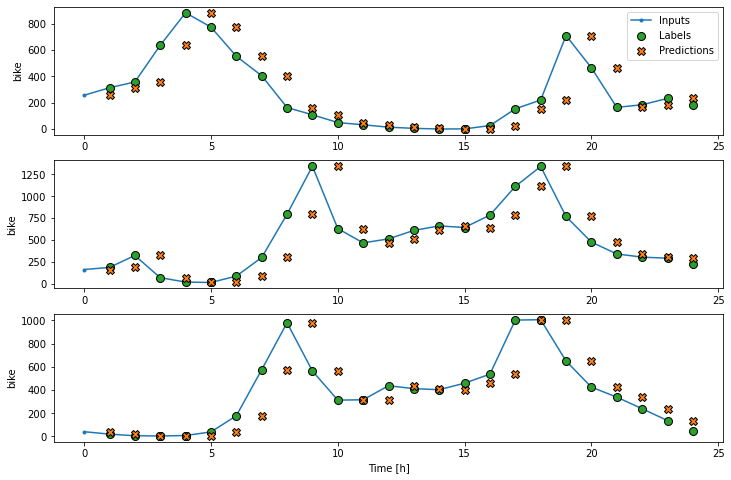

In [725]:
wide_window_tf.plot(baseline)

### Generalized Baseline Model

Our baseline model is designed to echo a single measurement from the past and use it as our current forecast. By designing the model thusly, there are no parameters and no training is necessary.

However there is no requirement that a model echoing one single measurement choose the most recent measurement as its input. Although that is the most obvious choice (and is likely to be the most performant here), it can be useful to see what would happen if we consider different offsets for this baseline approach.

#### with TF Windows

In [731]:
single_giantstep_window_8760 = tf_WindowGenerator(
    input_width=1, label_width=1, shift=8760,
    label_columns=['bike'])
#giant_val_eval = baseline.evaluate(single_giantstep_window_8760.val)

# ERROR: NO DATA !!!
# MOTIVATION for revising TSDSFA to use MASKS instead of separate DFs

In [733]:
single_giantstep_window_8759 = tf_WindowGenerator(
    input_width=1, label_width=1, shift=8759,
    label_columns=['bike'])
single_giantstep_window_8759

Total window size: 8760
Input indices: [0]
Label indices: [8759]
Label column name(s): ['bike']

In [734]:
giantstep_val_eval_8759 = baseline.evaluate(single_giantstep_window_8759.val)
giantstep_val_eval_8759
# just one data point

1/1 [==============================] - 0s 6ms/step - loss: 4.0000 - mean_absolute_error: 2.0000


[4.0, 2.0]

In [735]:
val_df.iloc[[0,-1]]

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
63829,0.000000,1.000000,0.000000,1.000000,0.006193,0.999981,-2.381445,-2.263656,0.471743,-1.258549,-0.148775,-0.114282,33,31
72588,-0.258819,0.965926,0.757972,0.652287,0.001305,0.999999,-0.616251,0.127000,0.011897,0.727684,0.249288,-0.114282,31,34


In [736]:
# Two data points:
single_giantstep_window_8758 = tf_WindowGenerator(
    input_width=1, label_width=1, shift=8758,
    label_columns=['bike'])
giantstep_val_eval_8758 = baseline.evaluate(single_giantstep_window_8758.val)
print(giantstep_val_eval_8758)
val_df.iloc[[0,1,-2,-1]]

1/1 [==============================] - 0s 7ms/step - loss: 306.5000 - mean_absolute_error: 17.5000
[306.5, 17.5]


,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
63829,0.000000,1.000000,0.000000,1.000000,0.006193,0.999981,-2.381445,-2.263656,0.471743,-1.258549,-0.148775,-0.114282,33,31
63830,0.258819,0.965926,0.037391,0.999301,0.006910,0.999976,-2.432202,-2.263656,0.559306,-0.622183,-0.148775,-0.114282,49,47
72587,-0.500000,0.866025,0.733052,0.680173,0.000588,1.000000,-0.604972,0.127000,0.091279,0.504066,-0.148775,-0.114282,50,51
72588,-0.258819,0.965926,0.757972,0.652287,0.001305,0.999999,-0.616251,0.127000,0.011897,0.727684,0.249288,-0.114282,31,34


We have seen the downside of splitting the data into three separate dataframes. Our model cannot produce (X,y) samples that overlap the boundary between train/val (or the boundary between val/test).

Better approach: store one property in WindowGenerator that can access the full dataframe. Use boolean masking or slicing to generate (X,y) samples instead

#### with rek Windows

In [738]:
single_giantstep_window_8760 = rek_WindowGenerator(
    input_width=1, label_width=1, shift=8760,
    label_columns=['bike'])
giant_val_eval = baseline.evaluate(single_giantstep_window_8760.val)

274/274 [==============================] - 2s 8ms/step - loss: 74809.5644 - mean_absolute_error: 163.8535


Now the giant_step Baseline model works.

Let's do some data exploration. Explore a variety of shifts to see how baseline model performance varies with size of shift

In [742]:
max_short_shift=400
short_shifts = list(range(1,max_short_shift))
val_eval_short_shifts = []
tic=time.time()
for shift in short_shifts:
    if (not(shift%40)):
        print(f'{shift}/{max_short_shift}')
    single_step_window_short = rek_WindowGenerator(
                    input_width=1, label_width=1, shift=shift,
                    label_columns=['bike'])
    val_eval_short_shifts.append(baseline.evaluate(single_step_window_short.val,verbose=0))
print(f'Time elapsed: {time.time()-tic} s')

20/400
40/400
60/400
80/400
100/400
120/400
140/400
160/400
180/400
200/400
220/400
240/400
260/400
280/400
300/400
320/400
340/400
360/400
380/400
Time elapsed: 345.35309863090515 s


In [746]:
max_days_shift=800
days_shifts = list(range(1,max_days_shift))
val_eval_days_shifts = []
tic=time.time()
for days in days_shifts:
    if (not(days%80)):
        print(f'{days}/{max_days_shift}')
    single_step_window_days = rek_WindowGenerator(
                    input_width=1, label_width=1, shift=24*days,
                    label_columns=['bike'])
    val_eval_days_shifts.append(baseline.evaluate(single_step_window_days.val,verbose=0))
print(f'Time elapsed: {time.time()-tic} s')
# Why did this slow to a crawl, only after 70% completed?

80/800
160/800
240/800
320/800
400/800
480/800
560/800
640/800
720/800
Time elapsed: 2763.4502844810486 s


In [751]:
with open('val_eval_short_shifts.txt', 'w') as outfile:
    json.dump(str(val_eval_short_shifts), outfile)
with open('val_eval_days_shifts.txt', 'w') as outfile:
    json.dump(str(val_eval_days_shifts), outfile)

#### Seasonality Viz

Text(0, 0.5, 'MAE')

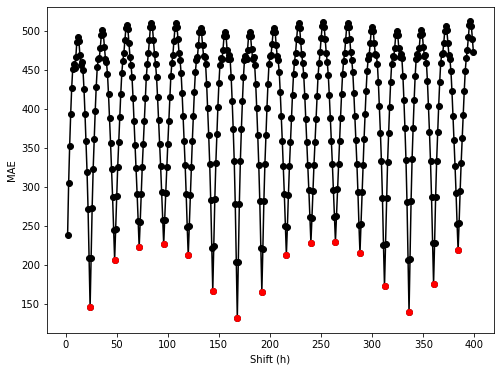

In [762]:
val_eval_short_shifts_MAE = [val_eval_short_shifts[j][1] for j in range(len(short_shifts))]
val_eval_short_shifts_MSE = [val_eval_short_shifts[j][0] for j in range(len(short_shifts))]
plt.plot(short_shifts,val_eval_short_shifts_MAE,'ko-')

plt.plot(list(filter(lambda x: (not(x%24)),short_shifts)),
         [mae for (j,mae) in enumerate(val_eval_short_shifts_MAE) if (not(short_shifts[j]%24))],
         'ro')
plt.xlabel('Shift (h)')
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

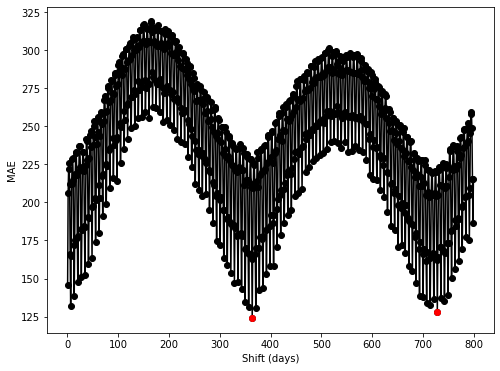

In [764]:
val_eval_days_shifts_MAE = [val_eval_days_shifts[j][1] for j in range(len(days_shifts))]
val_eval_days_shifts_MSE = [val_eval_days_shifts[j][0] for j in range(len(days_shifts))]
plt.plot(days_shifts,val_eval_days_shifts_MAE,'ko-')

plt.plot(list(filter(lambda x: (not(x%364)),days_shifts)),
         [mae for (j,mae) in enumerate(val_eval_days_shifts_MAE) if (not(days_shifts[j]%364))],
         'ro')
plt.xlabel('Shift (days)')
plt.ylabel('MAE')

In [770]:
# Re-define the two previous windows to use the new WindowGenerator class
single_step_window = rek_WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['bike'])
wide_window = rek_WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['bike'])

## Linear

In [771]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
# linear.summary()
    # => error, b/c no input_shape provided 

In [772]:
# We could have passed it an input_shape:
sswe_shape = single_step_window.example[0].shape   # (batch_size,window_size,features)
print(sswe_shape)
print()
linear_with_inputshape = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1,input_shape=(None,sswe_shape[1],sswe_shape[2]))
])
linear_with_inputshape.summary()

(32, 1, 14)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, None, 1, 1)        15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [773]:
# but it will be easier to instead let the model build only upon data ingestion
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
print()
linear.summary() 
# now we can print a summary also
    # mixed bag
        # 'Output Shape' is 'multiple'
            # indeterminate b/c input could change shape
        # but 'Param #' tells us the current number of parameters
            # even though that could also change with input shape

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             multiple                  15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [774]:
MAX_EPOCHS = 20

# Package compilation and model training into a single function:

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                                optimizer=tf.optimizers.Adam(),
                                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                                            validation_data=window.val,
                                            callbacks=[early_stopping])
    return history

In [775]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Train for 1644 steps, validate for 274 steps
Epoch 1/20
1644/1644 [==============================] - 8s 5ms/step - loss: 106495.1009 - mean_absolute_error: 198.8690 - val_loss: 55602.9620 - val_mean_absolute_error: 154.2515
Epoch 2/20
1644/1644 [==============================] - 7s 4ms/step - loss: 39642.9197 - mean_absolute_error: 126.8194 - val_loss: 53890.1794 - val_mean_absolute_error: 151.2896
Epoch 3/20
1644/1644 [==============================] - 7s 4ms/step - loss: 38020.7284 - mean_absolute_error: 123.3194 - val_loss: 51215.8132 - val_mean_absolute_error: 146.5763
Epoch 4/20
1644/1644 [==============================] - 7s 4ms/step - loss: 35927.1218 - mean_absolute_error: 118.7307 - val_loss: 48327.7954 - val_mean_absolute_error: 141.0129
Epoch 5/20
1644/1644 [==============================] - 7s 4ms/step - loss: 33794.9857 - mean_absolute_error: 113.9370 - val_loss: 45480.9670 - val_mean_absolute_error: 135.5824
Epoch 6/20
1644/1644 [==============================] - 7s 4ms/s

In [776]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


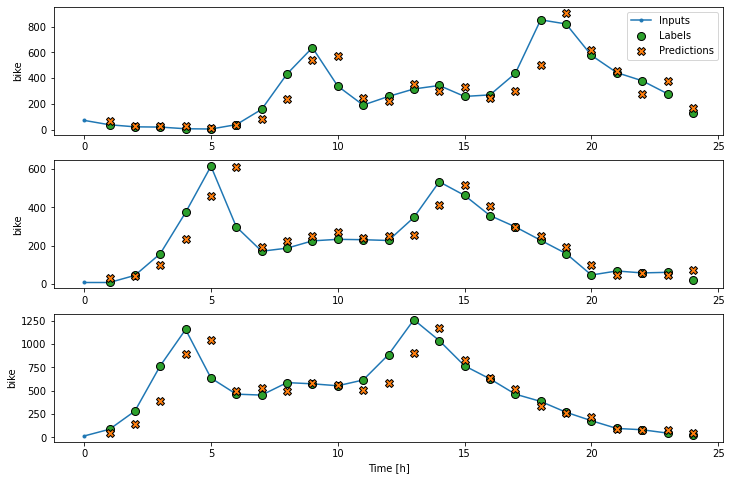

In [777]:
wide_window.plot(linear)

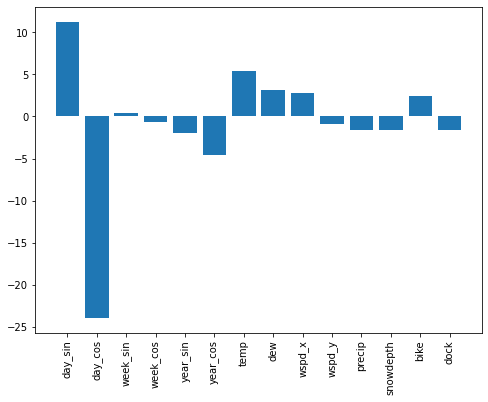

In [778]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [779]:
# Explain weights of Linear Model!

# Note: the ridership columns are not normalized, while the other columns are.

In [168]:
val_df.iloc[[0,2417,4817,7217]]        # year=2018

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
63829,0.000000,1.000000,0.000000,1.000000,0.006193,0.999981,-2.381445,-2.263656,0.471743,-1.258549,-0.148775,-0.114282,33,31
66246,-0.965926,-0.258819,0.652287,-0.757972,0.985945,-0.167072,-0.232758,-0.727178,-0.029245,0.928117,-0.148775,-0.114282,1430,1310
68646,-0.965926,-0.258819,-0.884115,-0.467269,-0.312041,-0.950068,1.335050,0.611381,-1.523021,1.027576,-0.148775,-0.114282,1740,1695
71046,-0.965926,-0.258819,-0.258819,0.965926,-0.893003,0.450051,0.083059,-0.221963,1.500495,0.501876,-0.148775,-0.114282,710,795


In [780]:
linear.layers[0].kernel[:,0].numpy()

array([ 11.257029  , -23.958395  ,   0.38210574,  -0.6522618 ,
        -1.9623111 ,  -4.6204805 ,   5.383042  ,   3.1400652 ,
         2.8187168 ,  -0.934367  ,  -1.5660747 ,  -1.653002  ,
         2.4327464 ,  -1.5759218 ], dtype=float32)

## Dense

In [781]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Train for 1644 steps, validate for 274 steps
Epoch 1/20
1644/1644 [==============================] - 10s 6ms/step - loss: 21983.4537 - mean_absolute_error: 87.3367 - val_loss: 27117.0765 - val_mean_absolute_error: 95.7997
Epoch 2/20
1644/1644 [==============================] - 10s 6ms/step - loss: 16299.2685 - mean_absolute_error: 75.6887 - val_loss: 23736.9100 - val_mean_absolute_error: 91.2875
Epoch 3/20
1644/1644 [==============================] - 10s 6ms/step - loss: 14015.8363 - mean_absolute_error: 70.4851 - val_loss: 17590.8164 - val_mean_absolute_error: 80.5404
Epoch 4/20
1644/1644 [==============================] - 10s 6ms/step - loss: 11617.6909 - mean_absolute_error: 64.5839 - val_loss: 14708.8861 - val_mean_absolute_error: 71.7492
Epoch 5/20
1644/1644 [==============================] - 10s 6ms/step - loss: 10278.1502 - mean_absolute_error: 60.7207 - val_loss: 14093.1007 - val_mean_absolute_error: 69.7105
Epoch 6/20
1644/1644 [==============================] - 10s 6ms/step -

## Multi-Step Dense

In [782]:
# Temporary Misnomer: no Convolutions here quite yet

CONV_WIDTH = 3
conv_window = rek_WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['bike'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['bike']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

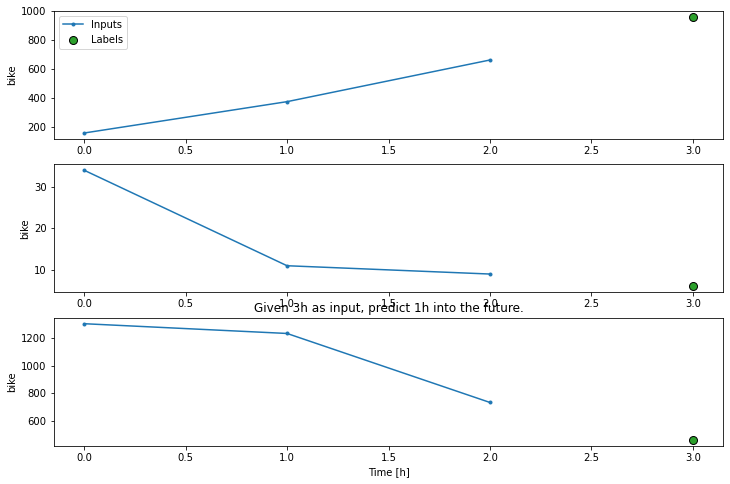

In [783]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [784]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [785]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [786]:
multi_step_dense.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          multiple                  0         
_________________________________________________________________
dense_47 (Dense)             multiple                  1376      
_________________________________________________________________
dense_48 (Dense)             multiple                  1056      
_________________________________________________________________
dense_49 (Dense)             multiple                  33        
_________________________________________________________________
reshape_6 (Reshape)          multiple                  0         
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [787]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

274/274 [==============================] - 1s 3ms/step - loss: 8698.3483 - mean_absolute_error: 55.8244


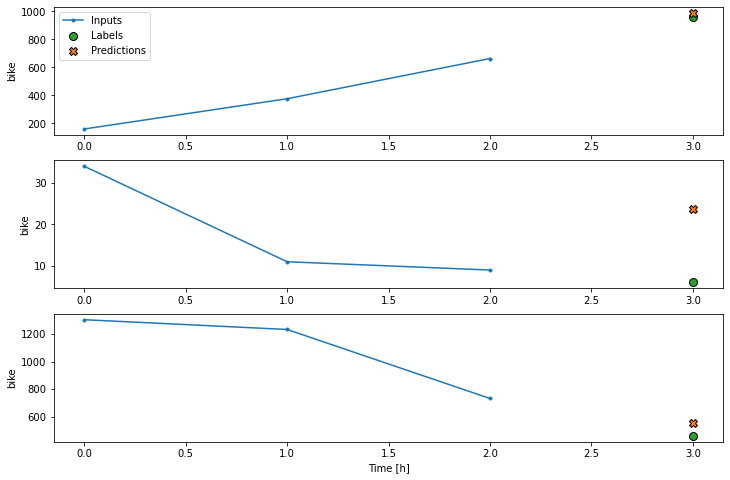

In [788]:
conv_window.plot(multi_step_dense)

Disadvantage of dense models: 

The model as defined can be compiled and trained with arbitrary input shape, but now that it has been fit, it will only work for input windows of exactly this shape

In [789]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 14)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,336], In[1]: [42,32] [Op:MatMul]


In [790]:
# Two different 32s (first is batch_size, second is dense_output)
# The inner numbers (336 vs 42) are what need to match

## CNN

However, we can fix this by using a convolutional model instead of a dense model. 

By starting with a 1-D convolutional layer, the same model can be applied to a time window of arbitrary size (as long as it is >= CONV_WIDTH)

In [793]:
conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32,
                                                     kernel_size=(CONV_WIDTH,),
                                                     activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
])
# don't need to provide input_shape

In [794]:
# conv_model.summary()
# ! ValueError: This model has not yet been built

In [795]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
print()
print(conv_model.summary())

Conv model on `conv_window`
Input shape: (32, 3, 14)
Output shape: (32, 1, 1)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            multiple                  1376      
_________________________________________________________________
dense_52 (Dense)             multiple                  1056      
_________________________________________________________________
dense_53 (Dense)             multiple                  33        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________
None


In [796]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

274/274 [==============================] - 1s 4ms/step - loss: 13829.8980 - mean_absolute_error: 72.1317


Now we can use this model to generate an array of predictions for windows of arbitary size. (Each output considers the three preceding time steps)

Let's use the wide window. Need to ensure that model output shape matches shape of labels, so extend INPUT_WIDTH by 2:

In [797]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1) # ***
wide_conv_window =  tf_WindowGenerator(
        input_width=INPUT_WIDTH,
        label_width=LABEL_WIDTH,
        shift=1,
        label_columns=['bike'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['bike']

In [798]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [799]:
# Notice: 24 redundant training examples within one batch now, except at edges
    # price for flexibility of model application to any size window

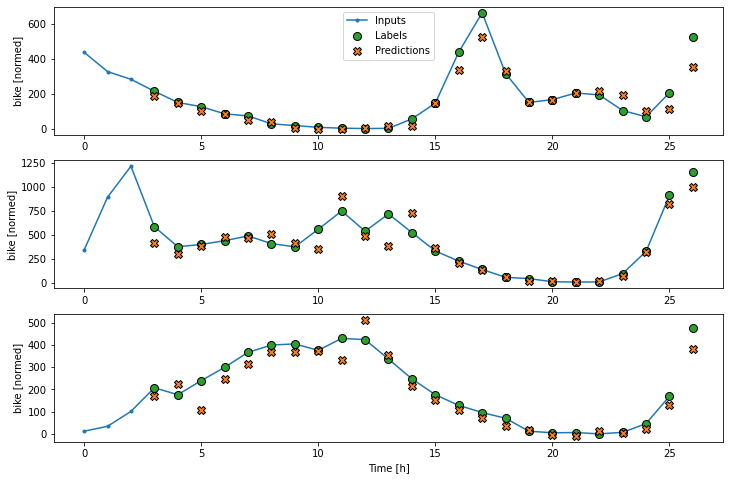

In [800]:
wide_conv_window.plot(conv_model)

## RNN (LSTM)

### Sequence: 24 outputs

In [811]:
lstm24_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] ===> [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
])


In [812]:
# return_sequences=True

# Model can train on numerous outputs at a time.
# We will see that this introduces a bias for the earliest samples. 
    # First output cannot see preceding data, just an initialized LSTM cell state
        # Should do no better than the sequence-ignorant models from above
        # Later outputs should benefit from the gradual evolution of cell state

In [813]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['bike']

In [814]:
# We will need the inputs and labels to be the same length
# Let's choose the wide_window:

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm24_model(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


In [815]:
lstm24_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               multiple                  6016      
_________________________________________________________________
dense_55 (Dense)             multiple                  33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [816]:
[ww.shape for ww in lstm24_model.weights] # 6049 trainable params:

[TensorShape([14, 128]),
 TensorShape([32, 128]),
 TensorShape([128]),
 TensorShape([32, 1]),
 TensorShape([1])]

In [817]:
history = compile_and_fit(lstm24_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM24'] = lstm24_model.evaluate(wide_window.val)
performance['LSTM24'] = lstm24_model.evaluate(wide_window.test, verbose=0)

274/274 [==============================] - 1s 5ms/step - loss: 19156.6387 - mean_absolute_error: 67.8883


In [818]:
# 25 points in wide_window
# so #samples in VAL or TEST set
    # now ===> 8760-(25-1) = 8736 = 32*273

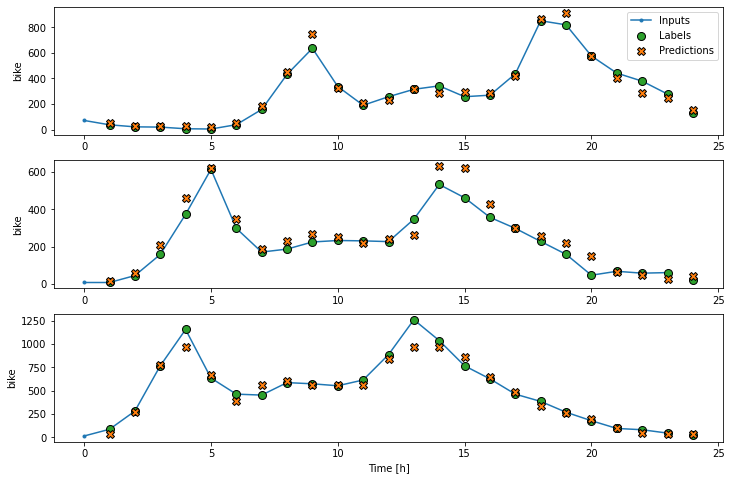

In [819]:
wide_window.plot(lstm24_model)

In [820]:
# Plot Overall Performance Results

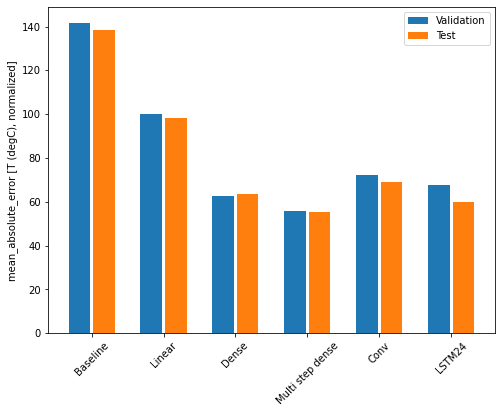

In [821]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm24_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
                     rotation=45)
_ = plt.legend()

In [822]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 138.3304
Linear      : 98.1632
Dense       : 63.7066
Multi step dense: 55.2375
Conv        : 68.8449
LSTM24      : 59.7083


In [823]:
# But recall: we expect this LSTM to understate performance

# Why?
    # Because with return_sequences=True, we're making predictions at every time step
    # But the steps near the beginning of the sequence haven't yet seen enough data 
        # to fully leverage the cell state

# Can we measure the LSTM performance separately by index within the sequence?
    # Expect to see performance much better later in sequence than at beginning

# Rerun test predictions manually so that we can score separately 
    # as a function of position within the time window

In [349]:
# Problem:
    # our Dataset objects were built to shuffle everything by default
        # (edit: after rewrite of make_dataset(), 
            # could go back & alter shuffle=>False for val and test)
    
    # I don't see a trivial way to use existing methods
        # to match predictions with targets, separately by position in time_window
    
    # .predict() ===> creates predictions for the dataset
        # but they're shuffled so they can't be matched up with targets
    # .evaluate() ===> generates predictions and does a match against targets
        # but then it aggregates over all positions before returning anything
        
# Solution Approaches:
    # 1) Clone and modify the evaluate method 
    # OR
    # 2) Redo predictions manually

In [825]:
[wide_window.column_indices[c] for c in wide_window.label_columns] # bike is column 12

[12]

In [826]:
# Option 2: Manually reconstruct 3D array corresponding to unshuffled test set:

tic=time.time()
TWS = wide_window.total_window_size    # 25
label_cols_idx = [wide_window.column_indices[c] for c in wide_window.label_columns] 

test_X=tf.stack([test_df.iloc[t0+wide_window.input_indices,:].to_numpy() \
                        for t0 in range(len(test_df)-TWS+1)])
test_y=tf.stack([test_df.iloc[t0+wide_window.label_indices,label_cols_idx].to_numpy() \
                        for t0 in range(len(test_df)-TWS+1)])
print(test_X.shape)
print(type(test_X))
print(test_y.shape)
print(type(test_y))
print(time.time()-tic)

(8736, 24, 14)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(8736, 24, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
9.598976850509644


In [827]:
test_yhat = lstm24_model.predict(test_X)
print(test_yhat.shape)

(8736, 24, 1)


In [828]:
residuals24 = (test_yhat-test_y).numpy().squeeze(axis=-1)

MSE_pos_24 = ((residuals24**2).sum(axis=0))/len(residuals24)
MAE_pos_24 = (np.abs(residuals24)).sum(axis=0)/len(residuals24)
MAE_pos_24.round(2)
# utilization of cell-state information improves late-window predictions !

array([101.36,  72.13,  65.29,  60.66,  58.63,  57.43,  57.04,  56.88,
        56.63,  56.48,  56.4 ,  56.33,  56.31,  56.37,  56.41,  56.42,
        56.47,  56.51,  56.49,  56.47,  56.46,  56.47,  56.47,  56.47])

In [829]:
# The initial few positions of the window are pulling up the average MAE
print(np.mean(MAE_pos))
print(performance['LSTM24'][1])  # Why not exact match?


59.60775812728938
59.7083


### Sequence: 1 output

In [848]:
# What happens if we allow full cell-state warmup for all predictions?
# always predict based on 24h of recent data
# return_sequences=False
# need a different window definition

In [849]:
lstm01_window = rek_WindowGenerator(
        input_width=24,label_width=1,shift=1,
        label_columns=['bike'])

lstm01_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['bike']

In [850]:
lstm01_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] ===> [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
])

In [851]:
print('Input shape:', lstm01_window.example[0].shape)
print('Output shape:', lstm01_model(lstm01_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 1)


In [852]:
lstm01_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               multiple                  6016      
_________________________________________________________________
dense_58 (Dense)             multiple                  33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [853]:
[ww.shape for ww in lstm01_model.weights] # 6049 trainable params:

[TensorShape([14, 128]),
 TensorShape([32, 128]),
 TensorShape([128]),
 TensorShape([32, 1]),
 TensorShape([1])]

In [854]:
# Same architecture as before ! 
# Technically it's a subset of the original network:
    # It doesn't output anything at the intermediate steps anymore
    # and thus it won't be including those intermediate steps in the loss metric either
    
# Q: How will this affect model performance?

In [855]:
    # Hypothesis:
        # Predictions in late steps will improve
        # Model could presumably find a better optimum for late-step predictions
            # if it were not simultaneously trying to minimize early-step loss also

In [856]:
history = compile_and_fit(lstm01_model, lstm01_window)

IPython.display.clear_output()
val_performance['LSTM01'] = lstm01_model.evaluate(lstm01_window.val)
performance['LSTM01'] = lstm01_model.evaluate(lstm01_window.test, verbose=0)

274/274 [==============================] - 1s 4ms/step - loss: 32035.9389 - mean_absolute_error: 90.6650


In [857]:
# Nope, it's much worse!

# Why?

In [858]:
# Answer: We've effectively reduced the size of the dataset
    # each sequence input produces 1 output now vs 24 earlier

In [859]:
# Using return_sequences=True, we were doing data augmentation ... sort of.
# Each output label was getting predicted 24 separate times
    # using different amounts of prior data for each of those 24 samples

In [860]:
# However, training still takes almost as long (11s vs 13s per epoch)
    # because 
        # training process changes very little
            # same model architecture
            # same batch_size
            # same total number of samples
        # what does change?
            # 23 fewer gradients to compute (first 23 time steps aren't outputting)
            # Loss function contains fewer terms to add up

### Sequence: 18 outputs

In [861]:
# Perhaps there is a useful middle ground?

# We saw that lstm0 improves greatly with the first few timesteps in sequence
    # but no more improvement after about six steps

# Is there a way to set return_sequences=True, but discard some of the outputs ?
    # Lambda layer !

In [862]:
lstm18_window = rek_WindowGenerator(
        input_width=24,label_width=18,shift=1,
        label_columns=['bike'])

lstm18_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['bike']

In [863]:
lstm18_window.input_width

24

In [864]:
lstm18_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] ===> [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True,
                    input_shape=(lstm18_window.input_width,test_df.shape[1])),
        tf.keras.layers.Lambda(lambda x: x[:,6:,:]),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
])

In [865]:
lstm18_model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 24, 32)            6016      
_________________________________________________________________
lambda_2 (Lambda)            (None, 18, 32)            0         
_________________________________________________________________
dense_59 (Dense)             (None, 18, 1)             33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [866]:
[ww.shape for ww in lstm18_model.weights] # same 6049 trainable params

[TensorShape([14, 128]),
 TensorShape([32, 128]),
 TensorShape([128]),
 TensorShape([32, 1]),
 TensorShape([1])]

In [867]:
history = compile_and_fit(lstm18_model, lstm18_window)

IPython.display.clear_output()
val_performance['LSTM18'] = lstm18_model.evaluate(lstm18_window.val)
performance['LSTM18'] = lstm18_model.evaluate(lstm18_window.test, verbose=0)

274/274 [==============================] - 1s 5ms/step - loss: 17840.1308 - mean_absolute_error: 64.8931


In [868]:
# Option 2

tic=time.time()
TWS = lstm18_window.total_window_size    # 25
label_cols_idx = [lstm18_window.column_indices[c] for c in lstm18_window.label_columns] 

test_X=tf.stack([test_df.iloc[t0+lstm18_window.input_indices,:].to_numpy() \
                        for t0 in range(len(test_df)-TWS+1)])
test_y=tf.stack([test_df.iloc[t0+lstm18_window.label_indices,label_cols_idx].to_numpy() \
                        for t0 in range(len(test_df)-TWS+1)])
print(test_X.shape)
print(type(test_X))
print(test_y.shape)
print(type(test_y))
print(time.time()-tic)

(8736, 24, 14)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(8736, 18, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
10.252138137817383


In [869]:
test_yhat = lstm18_model.predict(test_X)
print(test_yhat.shape)

(8736, 18, 1)


In [870]:
residuals18 = (test_yhat-test_y).numpy().squeeze(axis=-1)

MSE_pos_18 = ((residuals18**2).sum(axis=0))/len(residuals18)
MAE_pos_18 = (np.abs(residuals18)).sum(axis=0)/len(residuals18)
MAE_pos_18.round(2)

array([59.48, 58.07, 57.54, 57.74, 57.77, 57.83, 57.89, 57.93, 57.96,
       57.94, 57.95, 57.99, 58.  , 58.  , 58.02, 58.03, 58.02, 58.03])

In [871]:
# Original MAE_pos:
print(MAE_pos_24.round(2))

[101.36  72.13  65.29  60.66  58.63  57.43  57.04  56.88  56.63  56.48
  56.4   56.33  56.31  56.37  56.41  56.42  56.47  56.51  56.49  56.47
  56.46  56.47  56.47  56.47]


LSTM18 has removed the biased time steps from the beginning of LSTM24.

However, it fails to match the performance of LSTM24 at any of the remaining time bins!

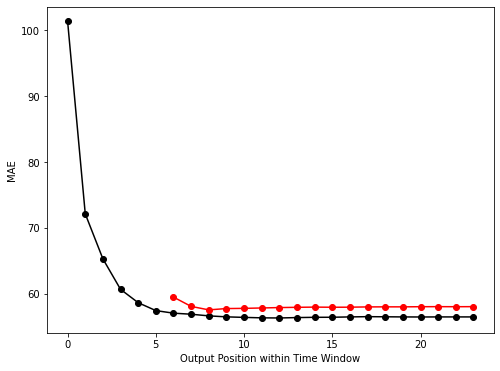

In [876]:
plt.plot(list(range(24)),MAE_pos_24.round(2),'ko-')
plt.plot(list(range(6,24)),MAE_pos_18.round(2),'ro-')
plt.xlabel('Output Position within Time Window')
plt.ylabel('MAE')
plt.show()

An attempt to minimize loss at early steps, even when results produced are mediocre, does appear to helpfully perturb your cell state into becoming more useful later in the window.

In [ ]:
# What would happen if training were allowed to continue?

# All these LSTM models were stopped after 20 epochs (and roughly equal training times)
    # but val loss was still decreasing in all cases 

## Multi-Output Models

You can output more than one label and train them simultaneously with the same network.

Sharing feature-space representations, while optimizing a prediction simultaneously over multiple labels, 
might benefit prediction measurements for all quantities.

In [880]:
# TensorFlow's weather example predicts all features here. 
# We'll stick with the two aggregated count variables, bike and dock

In [886]:
single_step_window_BD = rek_WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['bike','dock'])

wide_window_BD = rek_WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['bike','dock'])

for example_inputs, example_labels in wide_window_BD.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 2)


In [935]:
# create versions of these windows with label output ['dock'] as well
single_step_window_D = rek_WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['dock'])
wide_window_D = rek_WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['dock'])

single_step_window_B = rek_WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['bike'])
wide_window_B = rek_WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['bike'])



### Baseline

#### bike/dock individually

In [938]:
baseline_B = Baseline(label_index=column_indices['bike'])
baseline_B.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance_MOM = {}
performance_MOM = {}
val_performance_MOM['Baseline'] = baseline_B.evaluate(single_step_window_B.val)
performance_MOM['Baseline'] = baseline_B.evaluate(single_step_window_B.test)

274/274 [==============================] - 1s 3ms/step - loss: 29723.5474 - mean_absolute_error: 108.3605


In [939]:
baseline_D = Baseline(label_index=column_indices['dock'])
baseline_D.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance_MOM = {}
performance_MOM = {}
val_performance_MOM['Baseline'] = baseline_D.evaluate(single_step_window_D.val)
performance_MOM['Baseline'] = baseline_D.evaluate(single_step_window_D.test)

274/274 [==============================] - 1s 3ms/step - loss: 42581.5977 - mean_absolute_error: 133.2784


In [940]:
# On my first attempt, I accidentally mixed them up ...
baseline_X = Baseline(label_index=column_indices['bike'])
baseline_X.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance_MOM = {}
performance_MOM = {}
val_performance_MOM['Baseline'] = baseline_X.evaluate(single_step_window_D.val)
performance_MOM['Baseline'] = baseline_X.evaluate(single_step_window_D.test)
# ... and got a much lower MAE !
# (previous bike is a better predictor for dock than previous dock)

274/274 [==============================] - 1s 3ms/step - loss: 29720.8661 - mean_absolute_error: 108.3605


In [941]:
# The reverse doesn't work:
baseline_Z = Baseline(label_index=column_indices['dock'])
baseline_Z.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance_MOM = {}
performance_MOM = {}
val_performance_MOM['Baseline'] = baseline_Z.evaluate(single_step_window_B.val)
performance_MOM['Baseline'] = baseline_Z.evaluate(single_step_window_B.test)
# ... and got a much lower MAE !
# (previous bike is a better predictor for dock than previous dock)

274/274 [==============================] - 1s 3ms/step - loss: 60142.1469 - mean_absolute_error: 162.4337


#### Multi-Output Baseline

In [946]:
label_cols = ['bike','dock']
baseline_BD = Baseline(label_index=slice(12,13))
baseline_BD.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance_MOM = {}
performance_MOM = {}
val_performance_MOM['Baseline'] = baseline.evaluate(single_step_window_BD.val)
performance_MOM['Baseline'] = baseline.evaluate(single_step_window_BD.test)

274/274 [==============================] - 1s 3ms/step - loss: 51353.0852 - mean_absolute_error: 147.8560


In [949]:
single_step_window_BD.make_dataset

<bound method rek_make_dataset of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['bike', 'dock']>

In [948]:
print_batch_structure(single_step_window_BD.val)

273 batches of size 32
                          Inputs: (32, 1, 14), Labels: (32, 1, 14)
1 batches of size 24
                          Inputs: (24, 1, 14), Labels: (24, 1, 2)


In [ ]:
# why is this worse than either? Shouldn't it be the mean

In [914]:
vt = ['val','test']
n = len(df_TWAI)
calc_baseline_mae={}
for key in vt:
    calc_baseline_mae[key]={}
    my_slice = splitter_slices[27][key]
    my_range = range(my_slice.start,my_slice.stop,my_slice.step or 1)
    for lab in ['bike','dock']:
        coldex = column_indices[lab]
        calc_baseline_mae[key][lab] = \
                sum([abs(df_TWAI.iloc[j,coldex]-df_TWAI.iloc[j-1,coldex]) for j in my_range])/(my_slice.stop-my_slice.start)

In [915]:
calc_baseline_mae

{'val': {'bike': 141.79269406392694, 'dock': 137.72614155251142},
 'test': {'bike': 138.33036529680365, 'dock': 133.27842465753426}}

In [903]:
item.stop or len(self)

72589

In [904]:
item = splitter_slices[27]['val']
range(item.start, item.stop, item.step or 1)

range(63829, 72589)

In [890]:
column_indices

{'day_sin': 0,
 'day_cos': 1,
 'week_sin': 2,
 'week_cos': 3,
 'year_sin': 4,
 'year_cos': 5,
 'temp': 6,
 'dew': 7,
 'wspd_x': 8,
 'wspd_y': 9,
 'precip': 10,
 'snowdepth': 11,
 'bike': 12,
 'dock': 13}

# Backup

## My Rewrite of Data Windowing

In [ ]:
# OBJECTIVE:
# Redesign the WindowGenerator class and timeseries_dataset_from_array

# 1) use masks rather than separating three dataframes train/val/test
    # solves the overlap problem in the time dimension
    # can allow more general non-contiguous windows
    # C/W/R:   different availabilities ???????
    
# 2) bug fix for timeseries_dataset_from_array
    # 
    # timesteps inside train window should be available as inputs for val predictions
    # 

### Window Generator

### Split Windows:

### Plot

### tf.data.Datasets

In [ ]:
#tf.keras.preprocessing.timeseries_dataset_from_array
# function added after tf 2.1
# can copy the source code here though

# also I found a bug in the existing version in TF: it doesn't use the whole array
# when sampling_rate > 1, it discards training examples near the end of the array for no good reason


In [ ]:
# TF's timeseries_dataset_from_array() is a nice starting point
# but ultimately fails to meet the desired use case

# Why rewrite TSDSFA?

    # 1) existing version: len(data) must match len(targets)
        # this plays poorly with the windowing concept
            # cf. 1-D convolution where padding=valid
                # the size should not match!
        # What I want is a function that accepts a time-coord mask
            # returns ds where targets are matched to that mask (e.g. choose the validation set)
    # 2) bug: num_seqs discards legitimate data near edge of ds,  when sampling_rate>1
    # 3) quantities that accumulate
        # one desired dimension of target output: lead_time
            # i.e. let's predict values for multiple lead times simultaneously
        # ideally, we'd pass an array that can be differenced
                    # to obtain the accumulated values over the span of lead_time
            # otherwise required pre-computation of 'targets' would scale with lead_time 
    # 4) I'd like to implement column down-selection
        # separately for:
            # input window
            # offset window
            # output window
        # this can produce multiple differently-shaped submatrices
    # 5) Also want to be able to access more than one array
        # e.g. cumulative vs. raw counts, should pass in separate arrays
        
    # 6) We want to be capable of looking at LONG-RANGE interactions
        # i.e. maybe one full year, two full years, etc. is a useful place to look?
            # How to 